<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/master/notebooks/Division_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the divided database



---



---



In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

raw_data_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/master/datasets/dataset_resampled.csv"

df = pd.read_csv(raw_data_url, index_col=False)
df = df.drop('Unnamed: 0', axis=1)

categorical_features = ['HOSPI_CODE_UCD', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df['DATE'] = pd.to_datetime(df['DATE'],
               format='%Y-%m-%d')  # Changed the type of date too

for column in categorical_features:
  df[column] = df[column].astype('string')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   HOSPI_CODE_UCD    2100 non-null   string        
 1   DATE              2100 non-null   datetime64[ns]
 2   ID_SITE_RATTACHE  2100 non-null   string        
 3   QUANTITY          2100 non-null   float64       
 4   CODE_ATC          2100 non-null   string        
 5   N_UFS             2100 non-null   float64       
 6   WEEK              2100 non-null   object        
 7   N_ETB             2100 non-null   float64       
 8   POPULATION        2100 non-null   float64       
 9   P_MEDICAL         2100 non-null   float64       
 10  PN_MEDICAL        2100 non-null   float64       
 11  LIT_HC            2100 non-null   float64       
 12  LIT_HP            2100 non-null   float64       
 13  SEJ_MCO           2100 non-null   float64       
 14  SEJ_HAD           2100 n

# 1 - Database formatting

## 1.1 - Data inconsistance handling

In [61]:
df = df.drop_duplicates()
df = df.dropna()

for column in numerical_features:
  zeros = (df[column] == 0).sum()
  print(f'Column: {column}' + f' number of zeros: {zeros}')

Column: N_UFS number of zeros: 0
Column: QUANTITY number of zeros: 109
Column: N_ETB number of zeros: 0
Column: POPULATION number of zeros: 0
Column: P_MEDICAL number of zeros: 0
Column: PN_MEDICAL number of zeros: 0
Column: LIT_HC number of zeros: 0
Column: LIT_HP number of zeros: 0
Column: SEJ_MCO number of zeros: 0
Column: SEJ_HAD number of zeros: 1575
Column: SEJ_PSY number of zeros: 525
Column: SEJ_SSR number of zeros: 0


## 1.2 - Separating databases by hospital

In [62]:
# Separating databases

df_grouped = df.copy()

n_medicines = df_grouped['HOSPI_CODE_UCD'].nunique()
print('Number of different medicines: ', n_medicines)


df_h1 = df_grouped[df_grouped["ID_SITE_RATTACHE"] == "HOSPI_1"]
df_h1 = df_h1.drop(columns=['ID_SITE_RATTACHE'])

df_h2 = df_grouped[df_grouped["ID_SITE_RATTACHE"] == "HOSPI_2"]
df_h2 = df_h2.drop(columns=['ID_SITE_RATTACHE'])

df_h3 = df_grouped[df_grouped["ID_SITE_RATTACHE"] == "HOSPI_3"]
df_h3 = df_h3.drop(columns=['ID_SITE_RATTACHE'])

df_h4 = df_grouped[df_grouped["ID_SITE_RATTACHE"] == "HOSPI_4"]
df_h4 = df_h4.drop(columns=['ID_SITE_RATTACHE'])

Number of different medicines:  21


# Helper functions

In [4]:
'''
   This function helps visualize the values of numerical columns in a DataFrame,
   making it easier to understand their patterns and distributions.
'''

def plot_df(df, n_cols=3):
    numerical_cols = df.select_dtypes(include=[int, float]).columns
    num_features = len(numerical_cols)
    n_rows = (num_features - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    for i, column in enumerate(numerical_cols):
        values = df[column].dropna()
        if not values.empty:
            ax = axes[i // n_cols, i % n_cols]
            ax.plot(values)
            ax.set_title('Values of: ' + str(column))
            ax.grid(True)
            plt.grid()

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()


In [5]:
'''
  This function provides a convenient way to visualize the distribution of numerical
  columns in a DataFrame using histograms with optional kernel density estimation.
'''

def visualize_distribution(df, data_type='numerical', n_cols=3):
    if data_type == 'numerical':
        columns = df.select_dtypes(include=[int, float]).columns
    elif data_type == 'categorical':
        columns = df.select_dtypes(include=[object, 'string']).columns
    else:
        raise ValueError("Invalid data_type parameter. Supported values: 'numerical', 'categorical'")

    if len(columns) == 0:
        raise ValueError("No columns of the specified data type found in the DataFrame.")

    num_features = len(columns)
    n_rows = m.ceil(num_features / n_cols)

    # Handle the case when n_rows or n_cols is 1
    if n_rows == 1:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 10))
        axes = [axes]  # Wrap the single axis in a list
    elif n_cols == 1:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(10, 20))
        axes = [[ax] for ax in axes]  # Convert each axis to a list
    else:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    # Set a predefined color palette
    palette = sns.color_palette("Set3", n_colors=num_features)

    for i, column in enumerate(columns):
        ax = axes[i // n_cols][i % n_cols]  # Access the axis correctly
        if data_type == 'numerical':
            sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
        elif data_type == 'categorical':
            sns.countplot(x=column, data=df, ax=ax, palette=[palette[i]])
            ax.tick_params(axis='x', rotation=45)
        ax.set(title='Distribution of: ' + str(column))

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols][i % n_cols])

    plt.tight_layout()
    plt.show()

In [6]:
'''
  Display unique values in dataframe
'''
def display_unique(df, kind = 'Categorical'):

  if kind == 'Categorical':
    features = df.select_dtypes(include=['object', 'string'])
  if kind == 'Numerical':
    features = df.select_dtypes(include=[int, float])
  if kind == 'Both':
    features = df.columns

  for column in features:
    print(f'\n Unique values of feature: {column}')
    print(df[column].unique())
    print('\n')

In [7]:
def kmeans_clustering(X, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, init = 'k-means++', n_init=1, max_iter=300)
    model.fit(X)
    return model



In [8]:
def evaluate_kmeans_clustering(X_train, X_test, n_clusters=2, metric='euclidean', verbose = False):
    model = kmeans_clustering(X_train, n_clusters)
    y_pred = model.predict(X_test)
    silhouette = metrics.silhouette_score(X_test, y_pred, metric=metric)
    davies_bouldin = metrics.davies_bouldin_score(X_test, y_pred)
    calinski_harabasz = metrics.calinski_harabasz_score(X_test, y_pred)

    if verbose:
      metrics_string = '#'*10+' Metrics for test split - '+f'{n_clusters} clusters '+'#'*10
      print()
      print('#'*len(metrics_string))
      print(metrics_string)
      print()
      print(f'Silhouette Score: {round(silhouette, 2)}')
      print(f'Davies-Bouldin Score: {round(davies_bouldin, 2)}')
      print(f'Calinski-Harabasz Score: {round(calinski_harabasz, 2)}')
      print()
      print('#'*len(metrics_string))
      print('#'*len(metrics_string))
      print()

    return silhouette, davies_bouldin, calinski_harabasz

In [10]:
def visualize_kmeans_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, calinski_scores):

  # Find optimal cluster numbers based on the scores
  s_max = np.argmax(s_scores)+2
  dbs_min = np.argmin(dbs_scores)+2
  calinski_max = np.argmax(calinski_scores)+2

  # Print the best scores and cluster numbers
  string_array = '#'*10 + ' Metrics best performance for different clusters ' + '#'*10
  len_string_array = len(string_array)
  print('-' * len_string_array)
  print('-' * len_string_array)
  print()
  print(string_array)
  print(f'Best score for Silhouette metric: {max(s_scores):.2f} for {s_max} clusters')
  print(f'Best score for Davies Bouldin metric: {min(dbs_scores):.2f} for {dbs_min} clusters')
  print(f'Best score for Calinski metric: {max(calinski_scores):.2f} for {calinski_max} clusters')
  print()
  print('-' * len_string_array)
  print('-' * len_string_array)
  print()

  # Plot Silhouette scores
  x = np.arange(min_clusters, max_clusters+1)

  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(x,s_scores)
  ax.set_xlabel('Number of Clusters')
  ax.set_ylabel('Silhouette Score')
  ax.set_title('Silhouette Scores for Different Cluster Numbers')
  ax.set_xticks(np.arange(2, max_clusters, 2))
  annot_max(x, s_scores)
  plt.show()

  # Plot Davies Bouldin Scores
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(x, dbs_scores)
  ax.set_xlabel('Number of Clusters')
  ax.set_ylabel('Davies Bouldin Score')
  ax.set_title('Davies Bouldin Scores for Different Cluster Numbers')
  ax.set_xticks(np.arange(0, max_clusters-2, 2), np.arange(2, max_clusters, 2))
  annot_min(x, dbs_scores, ax=ax)
  plt.show()

  # Plot Calinski scores
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(x,calinski_scores)
  ax.set_xlabel('Number of Clusters')
  ax.set_ylabel('Calinski Score')
  ax.set_title('Calinski Scores for Different Cluster Numbers')
  ax.set_xticks(np.arange(2, max_clusters, 2))
  annot_max(x, calinski_scores)
  plt.show()


In [11]:
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text = "x={:.1f}, y={:.2f}".format(xmax, ymax)
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60", color="black")  # Set arrow color to black
    kw = dict(xycoords='data', textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94, 0.96), **kw)



In [41]:
def annot_min(x, y, ax=None):
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text_min = "x={:.1f}, y={:.2f}".format(xmin, ymin)
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60", color="black")  # Set arrow color to black
    kw = dict(xycoords='data', textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text_min, xy=(xmin, ymin), xytext=(0.9, 0.3), **kw)

In [12]:
def plot_boxplot(df, column_name, n_cols=3):
    unique_medicines = df['HOSPI_CODE_UCD'].unique()
    num_medicines = len(unique_medicines)
    n_rows = (num_medicines - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    for i, medicine in enumerate(unique_medicines):
        subset = df[df['HOSPI_CODE_UCD'] == medicine]
        ax = axes[i // n_cols, i % n_cols]
        ax.boxplot(subset[column_name])
        ax.set_title('Boxplot of ' + column_name + ' for Medicine: ' + str(medicine))
        ax.grid(True)

    # Remove empty subplots
    if num_medicines < n_rows * n_cols:
        for i in range(num_medicines, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()


In [20]:
def plot_violin_boxplot_by_medicine(df, column_name, n_cols=3):
    unique_medicines = df['HOSPI_CODE_UCD'].unique()
    num_medicines = len(unique_medicines)
    n_rows = (num_medicines - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    for i, medicine in enumerate(unique_medicines):
        subset = df[df['HOSPI_CODE_UCD'] == medicine]
        ax = axes[i // n_cols, i % n_cols]

        # Create violin plot
        sns.violinplot(x=subset[column_name], ax=ax, inner="box")

        # Create boxplot
        sns.boxplot(x=subset[column_name], ax=ax, width=0.2, color='white', fliersize=4)

        ax.set_title('Violin Plot and Boxplot of ' + column_name + ' for Medicine: ' + str(medicine))
        ax.set_xlabel(column_name)
        ax.set_ylabel("Values")
        ax.grid(True)

    # Remove empty subplots
    if num_medicines < n_rows * n_cols:
        for i in range(num_medicines, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()


## 2 - Data treatment

The data treatment part was done in the notebook [Timeseries exploration](https://github.com/douglasmmachado/MedicineConsumption/blob/master/notebooks/Timeseries_Analysis.ipynb). In the present notebook, we are using a dataset without outliers and strange data

# Hospital 1

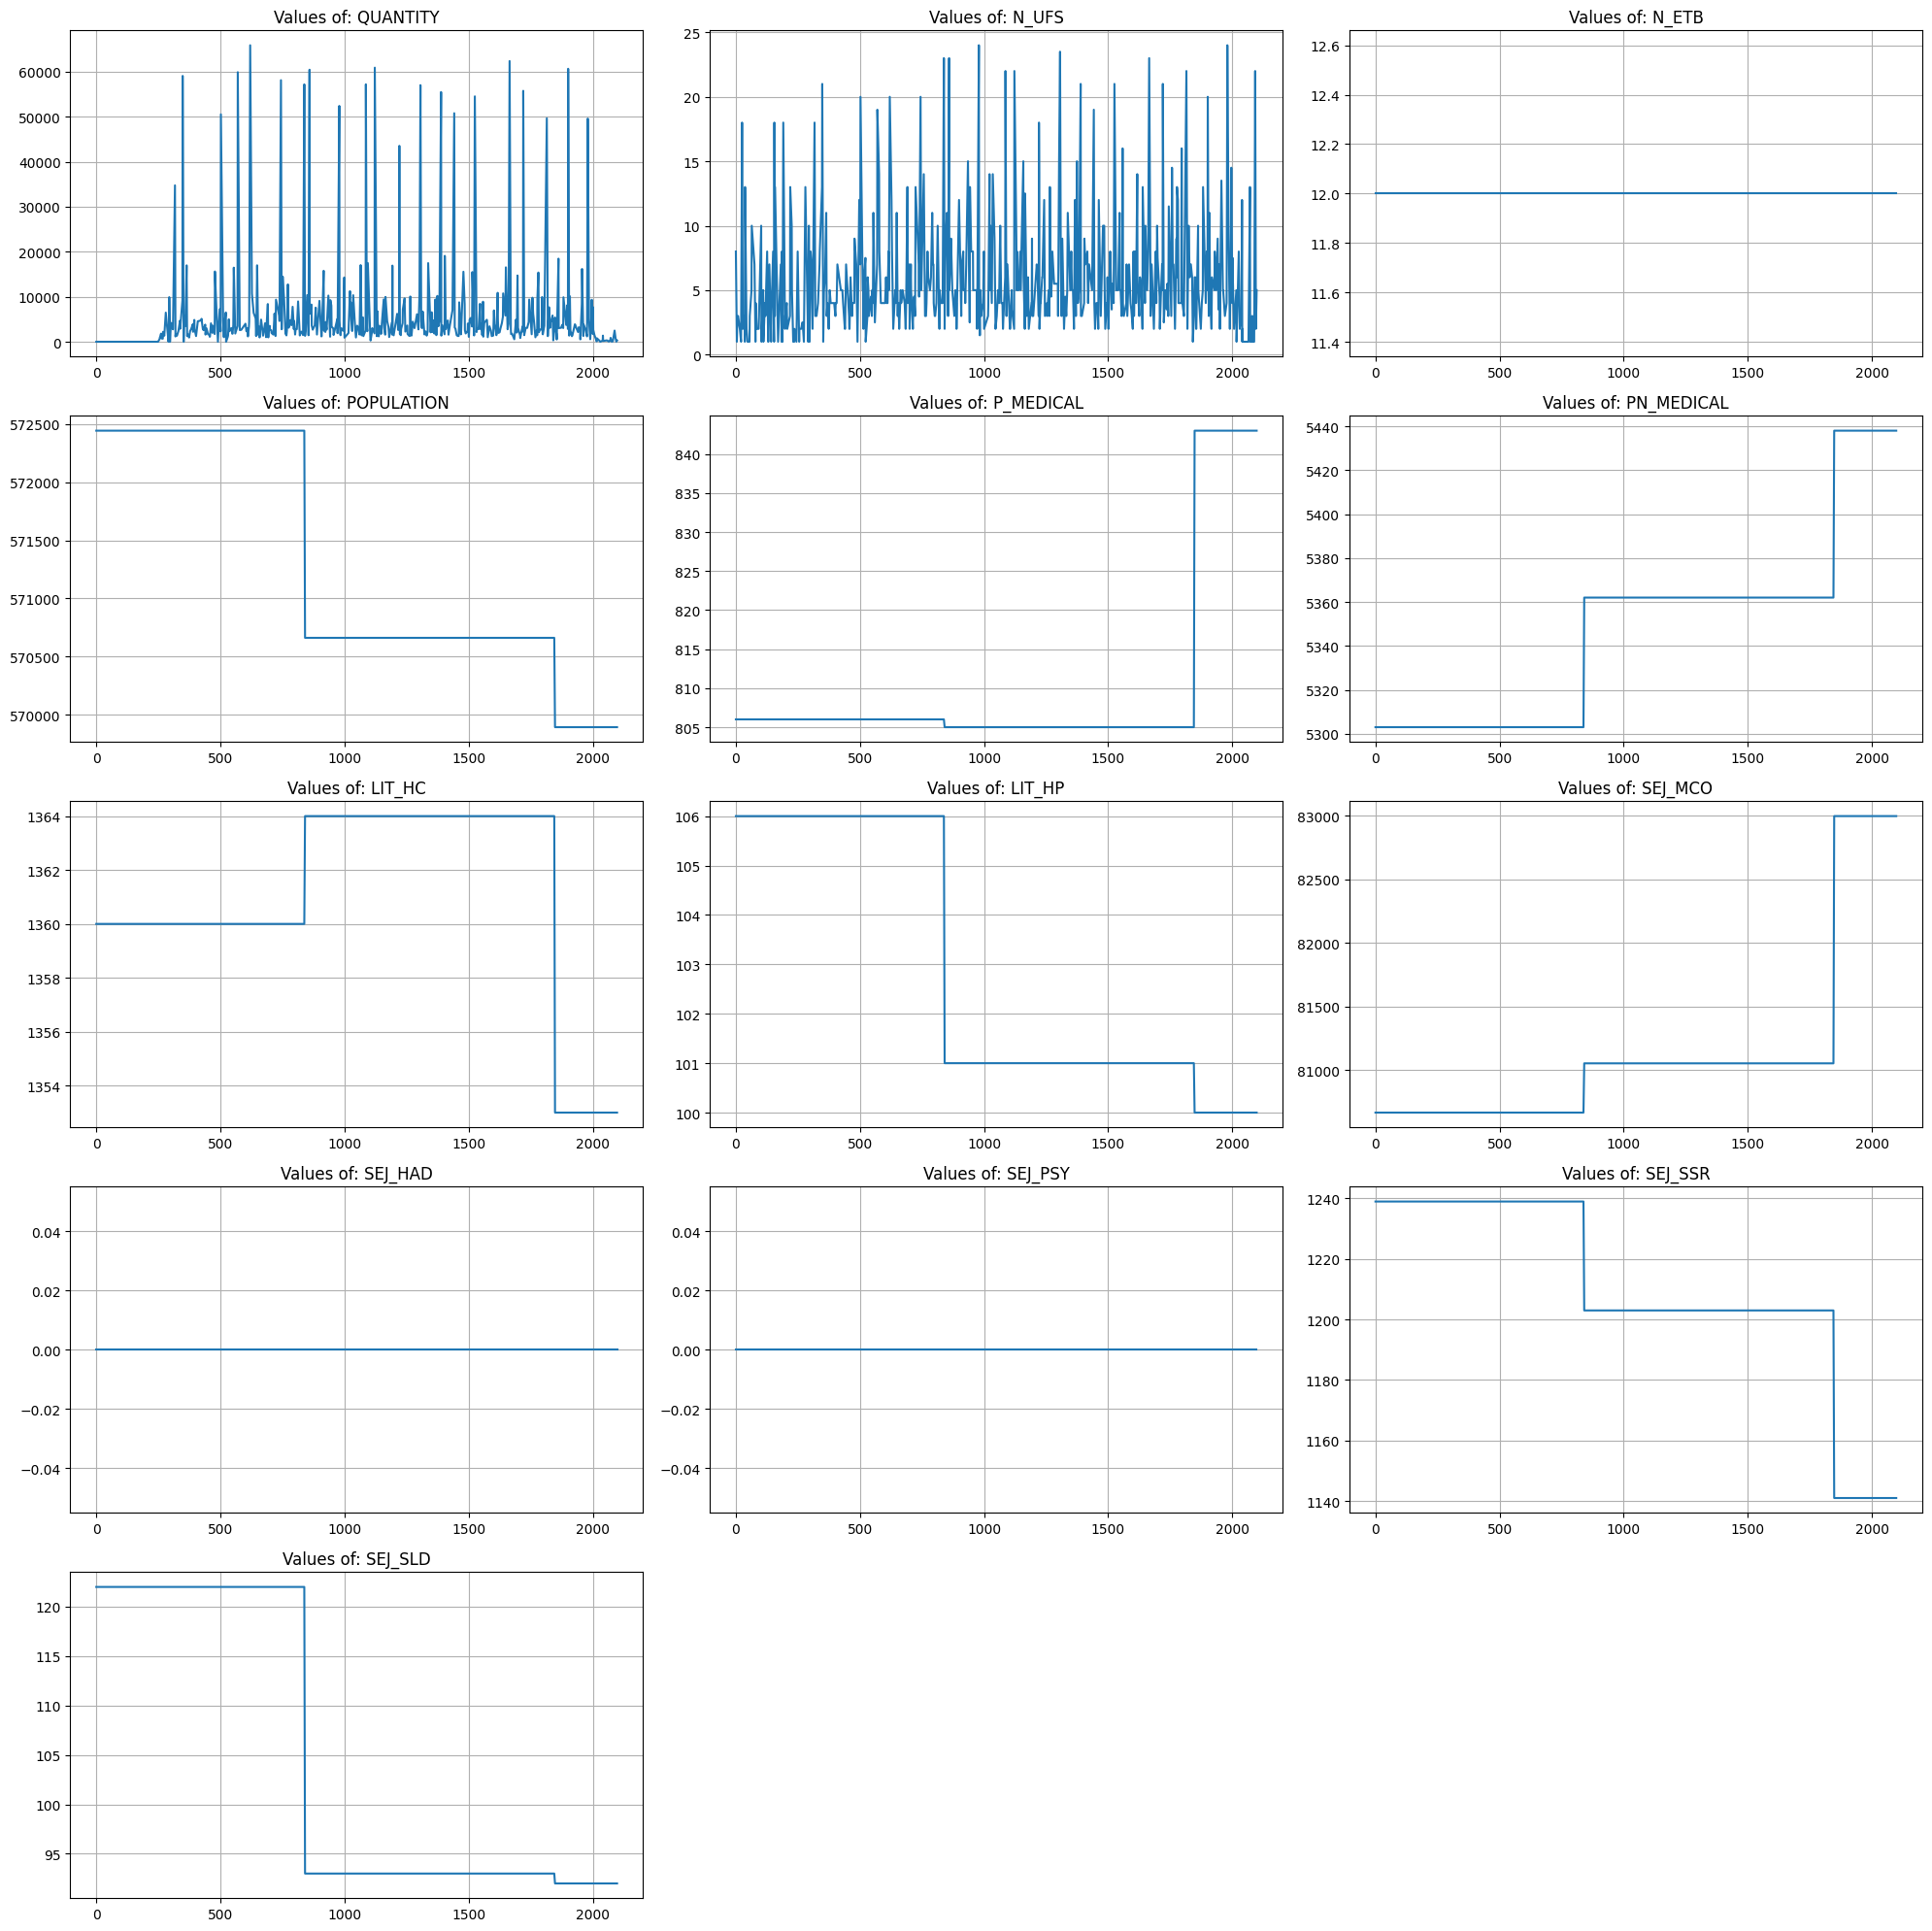

In [13]:
# Visualizing values of numerical features
plot_df(df_h1)

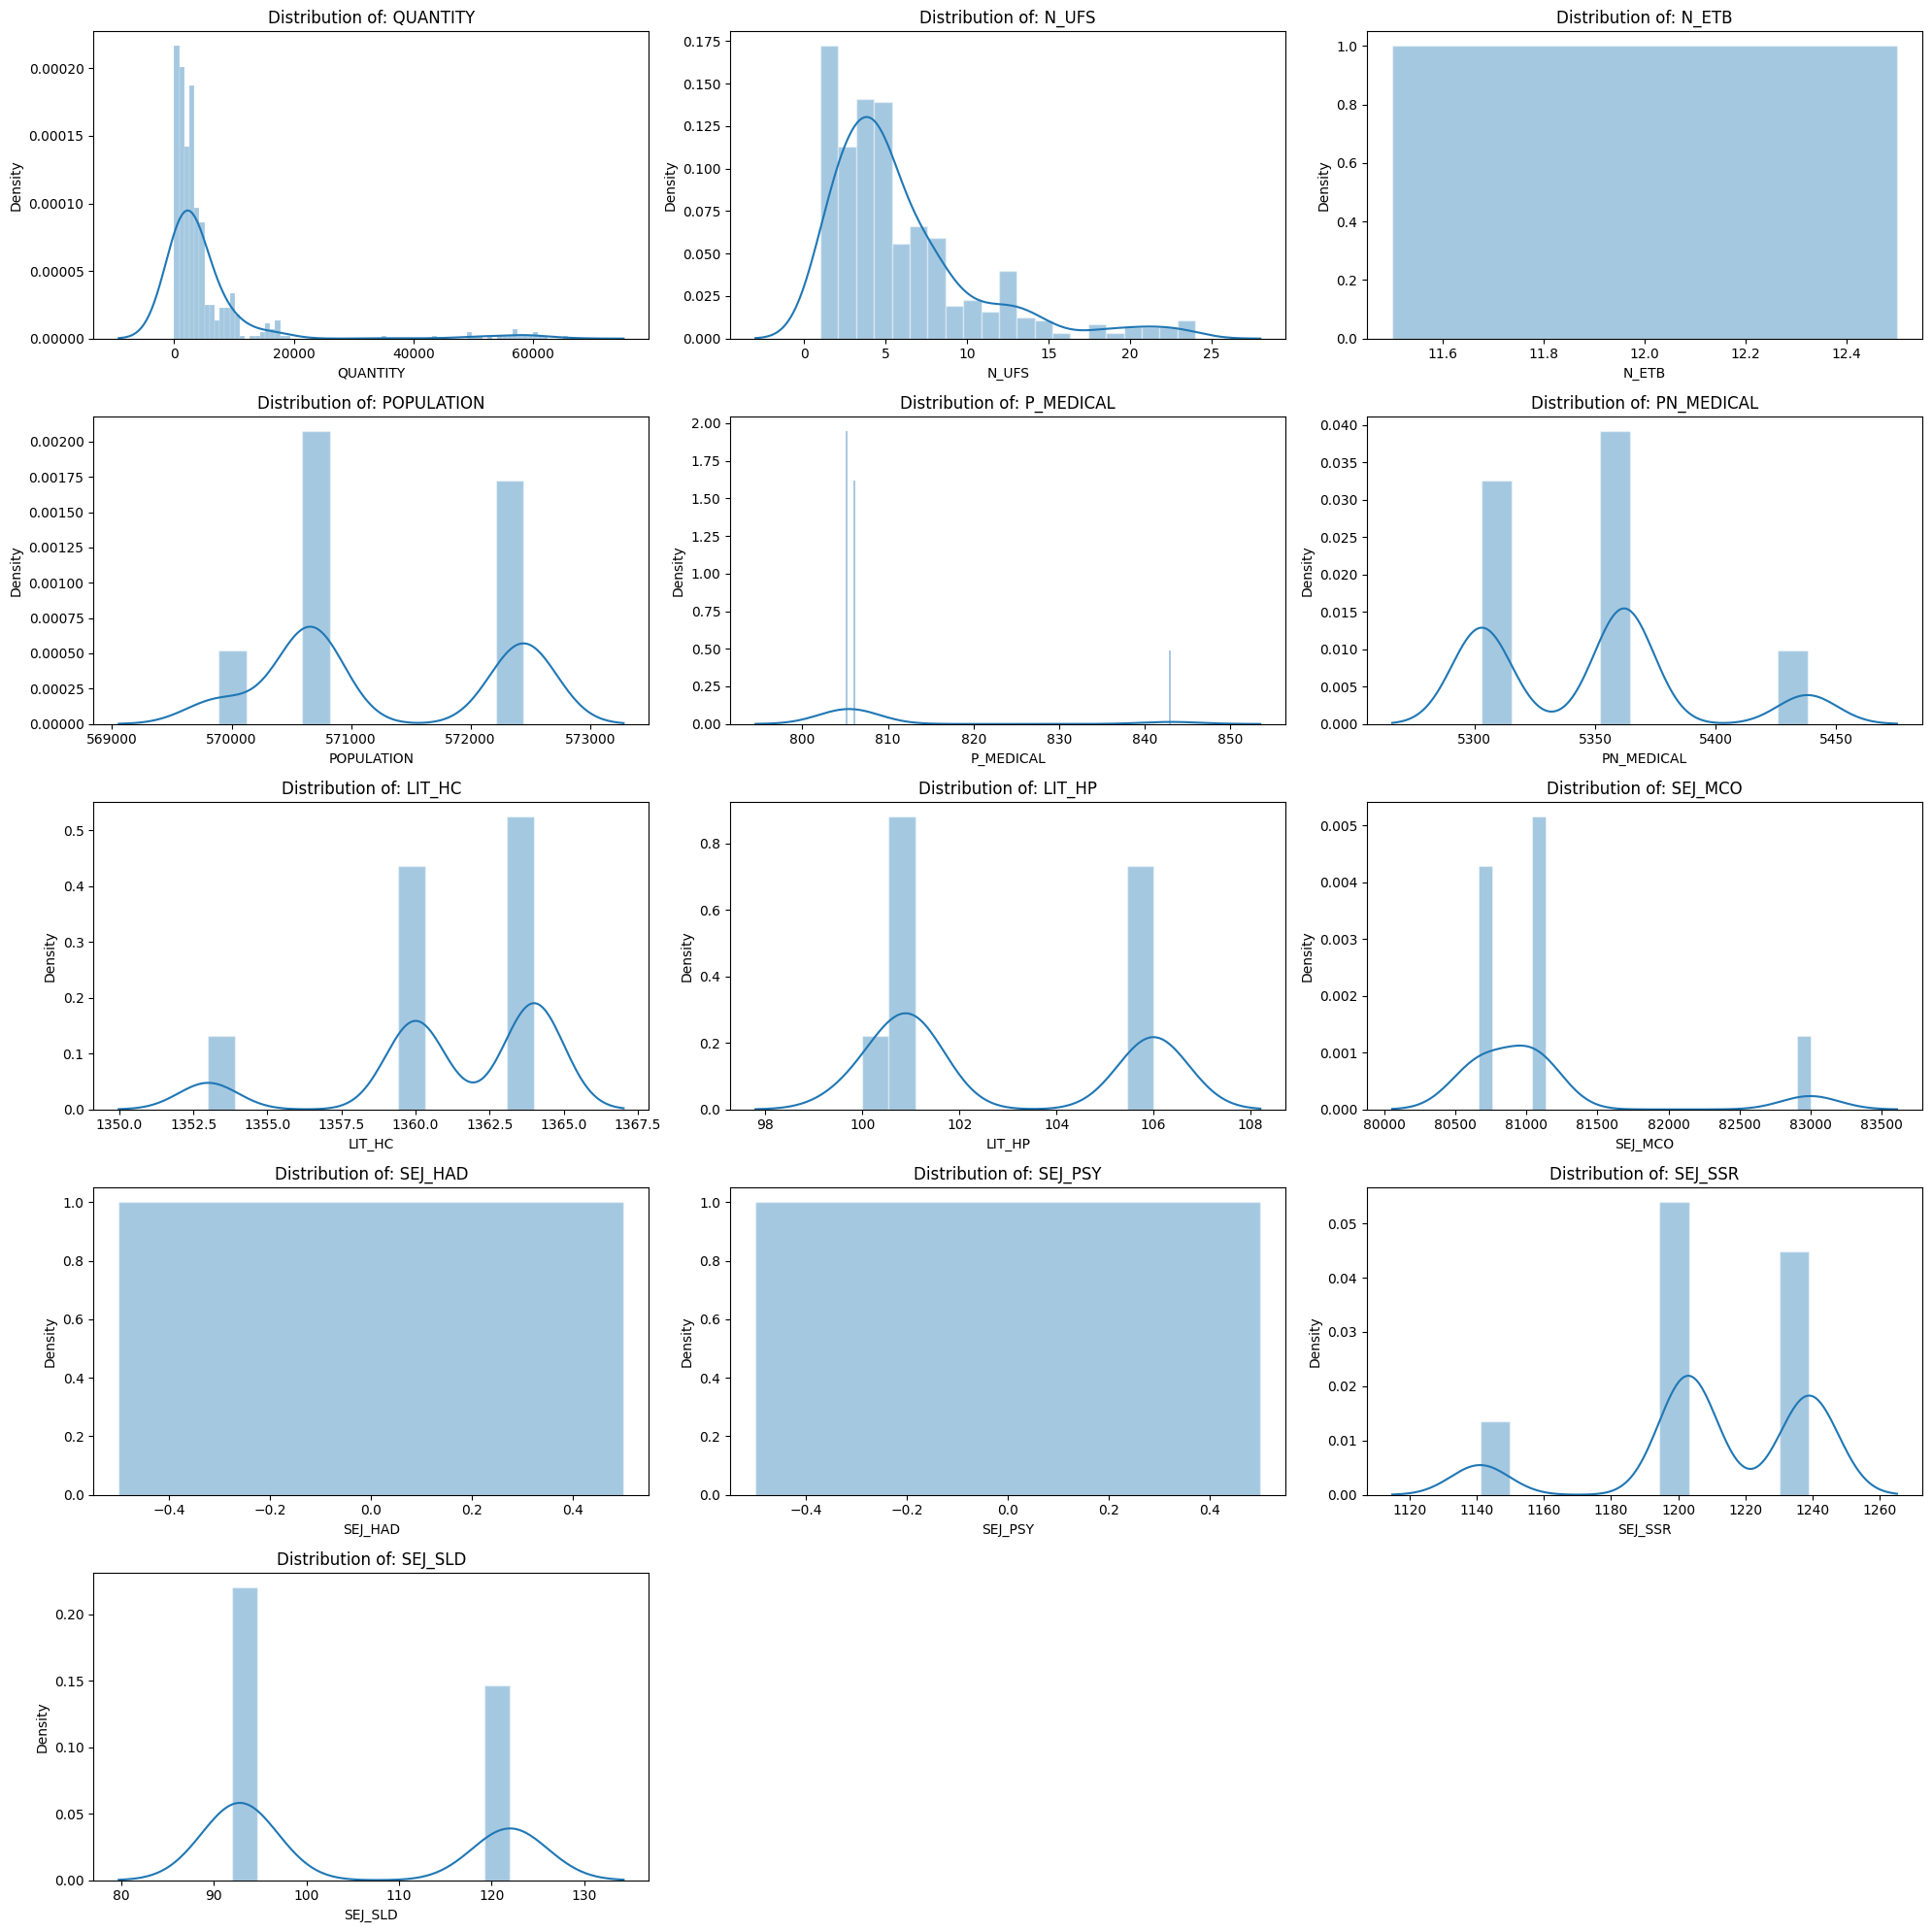

In [14]:
visualize_distribution(df_h1)

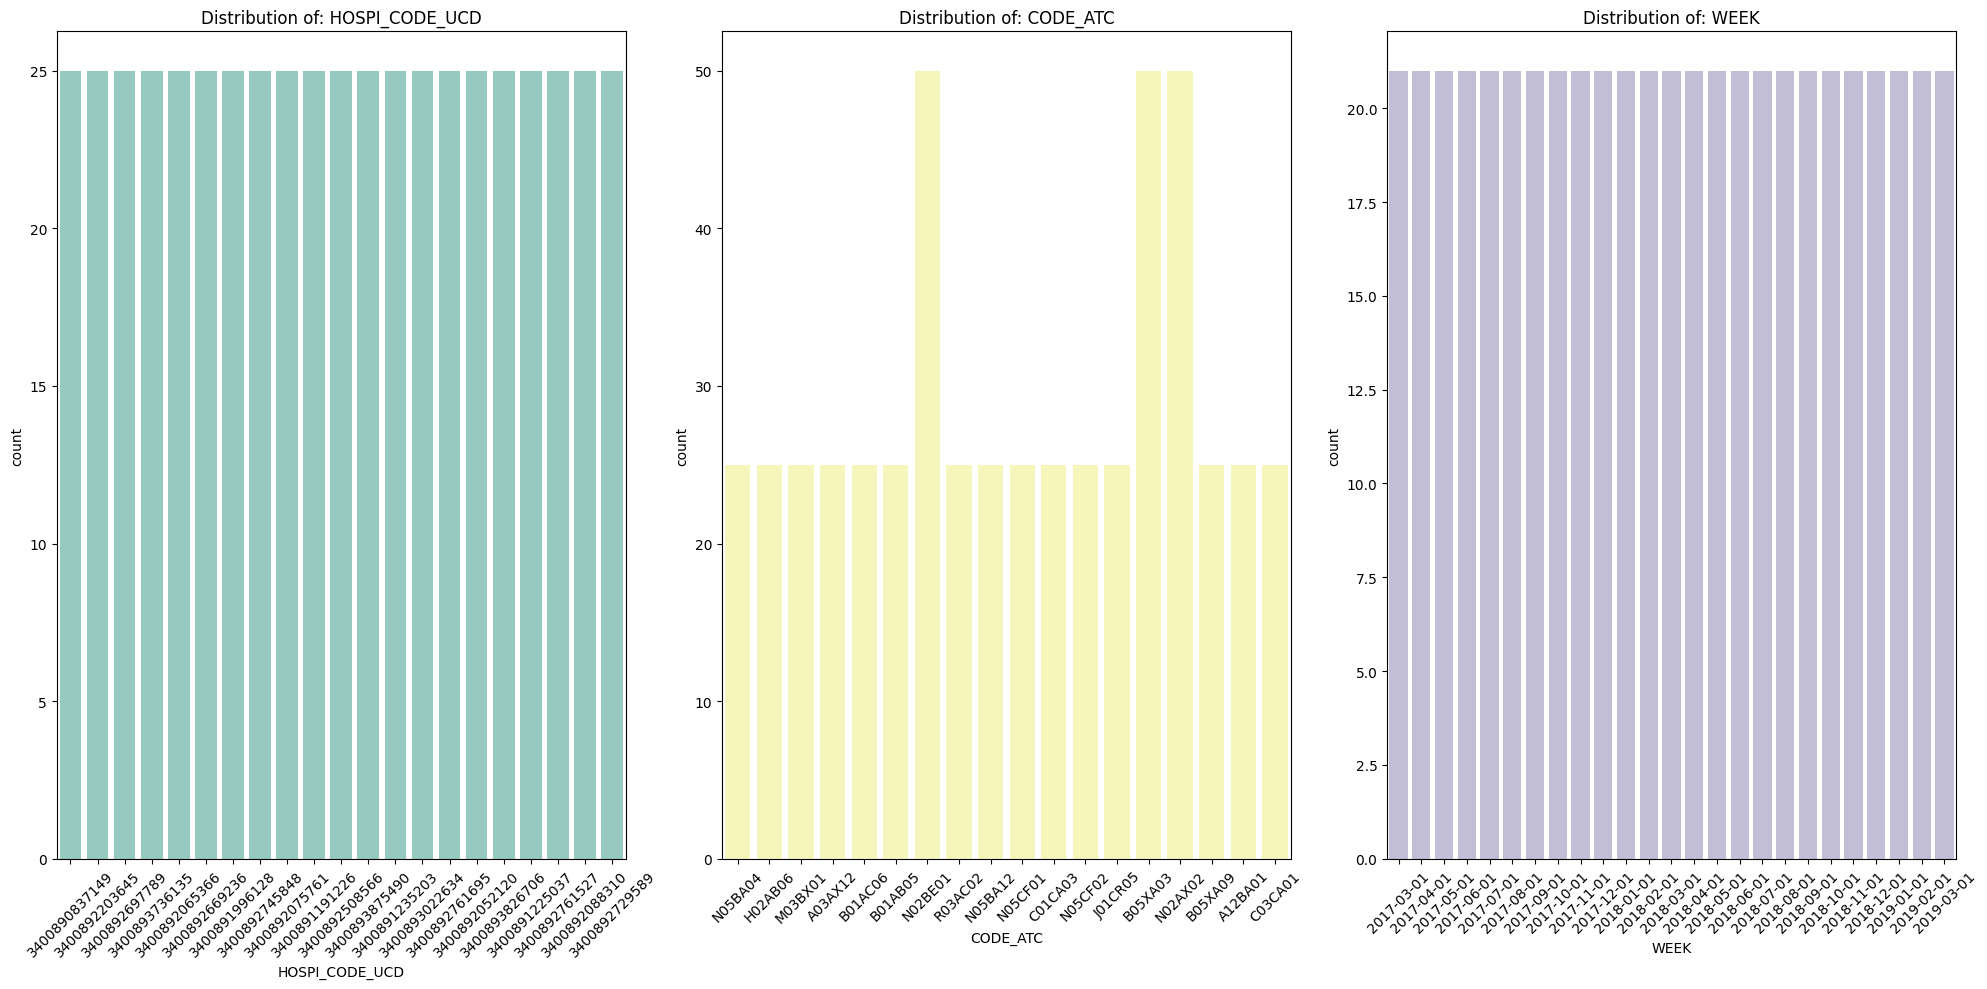

In [15]:
# Question to be asked:  As ID_REF and HOSPI_CODE_UCD are the same information, can we eliminate one column?
# Other question is why the pattern between the two variables are the similar, they are explaining the same thing?

visualize_distribution(df_h1, data_type='categorical')

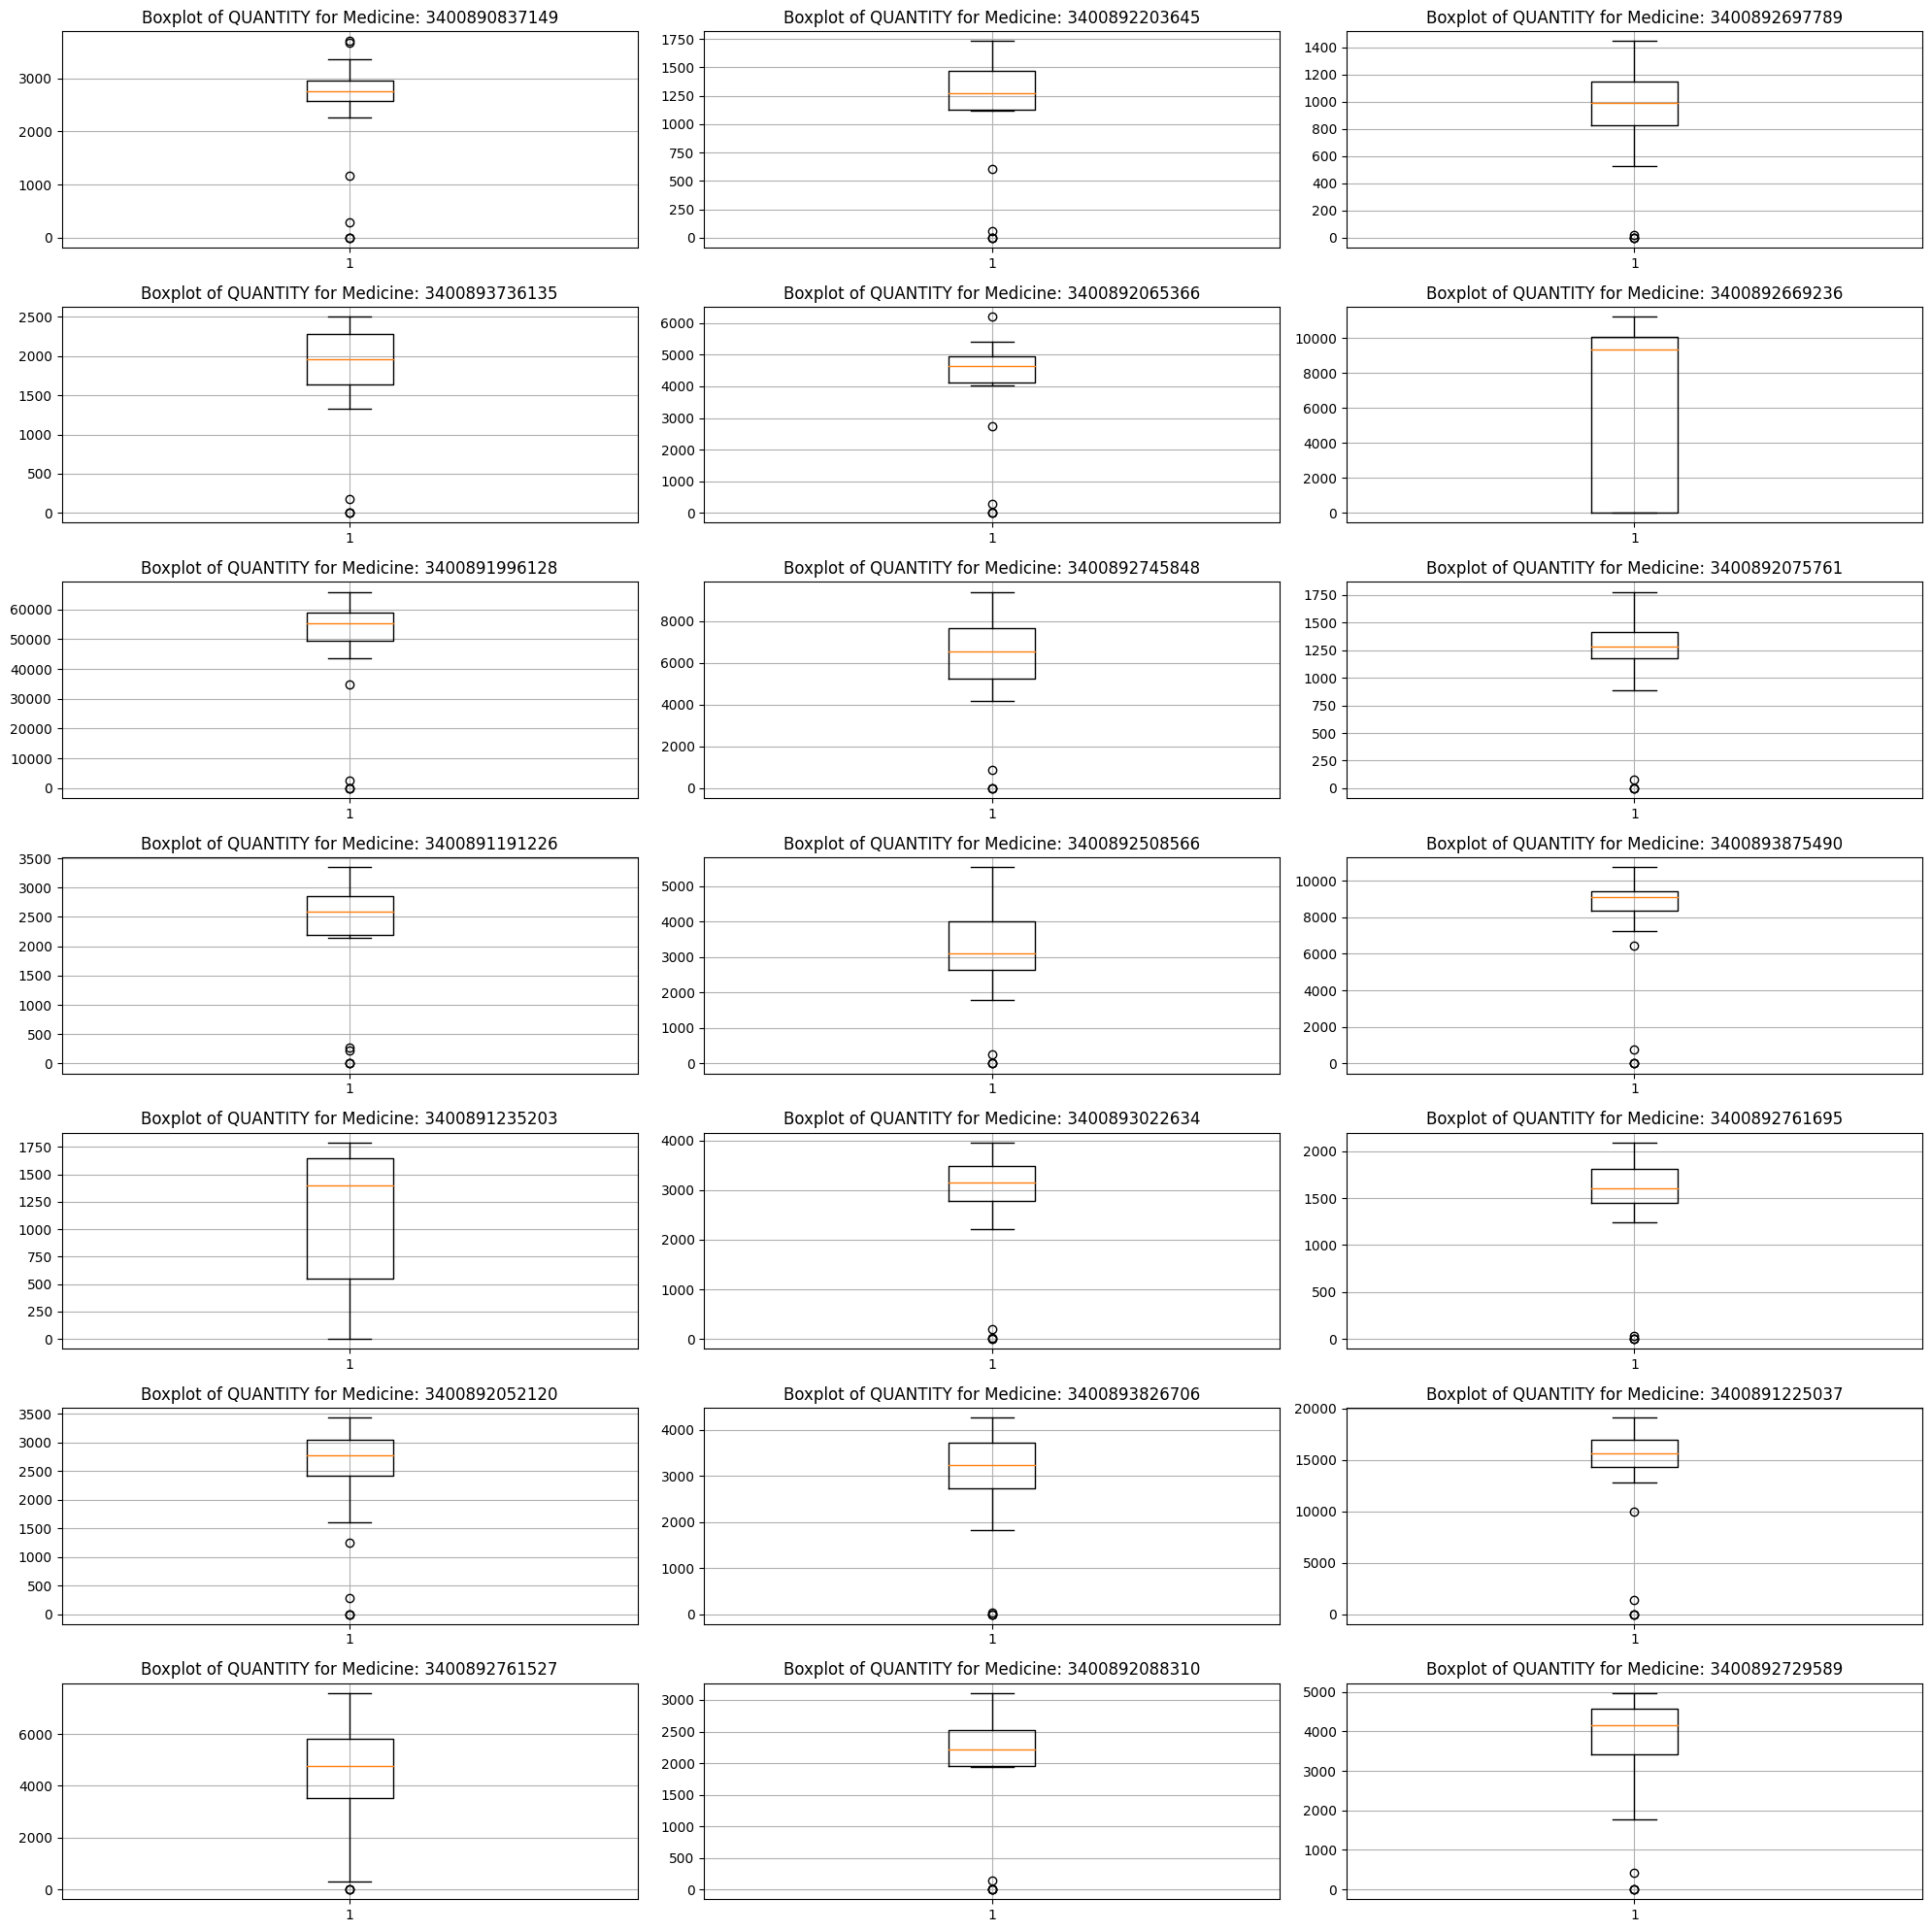

In [16]:
plot_boxplot(df_h1, 'QUANTITY')

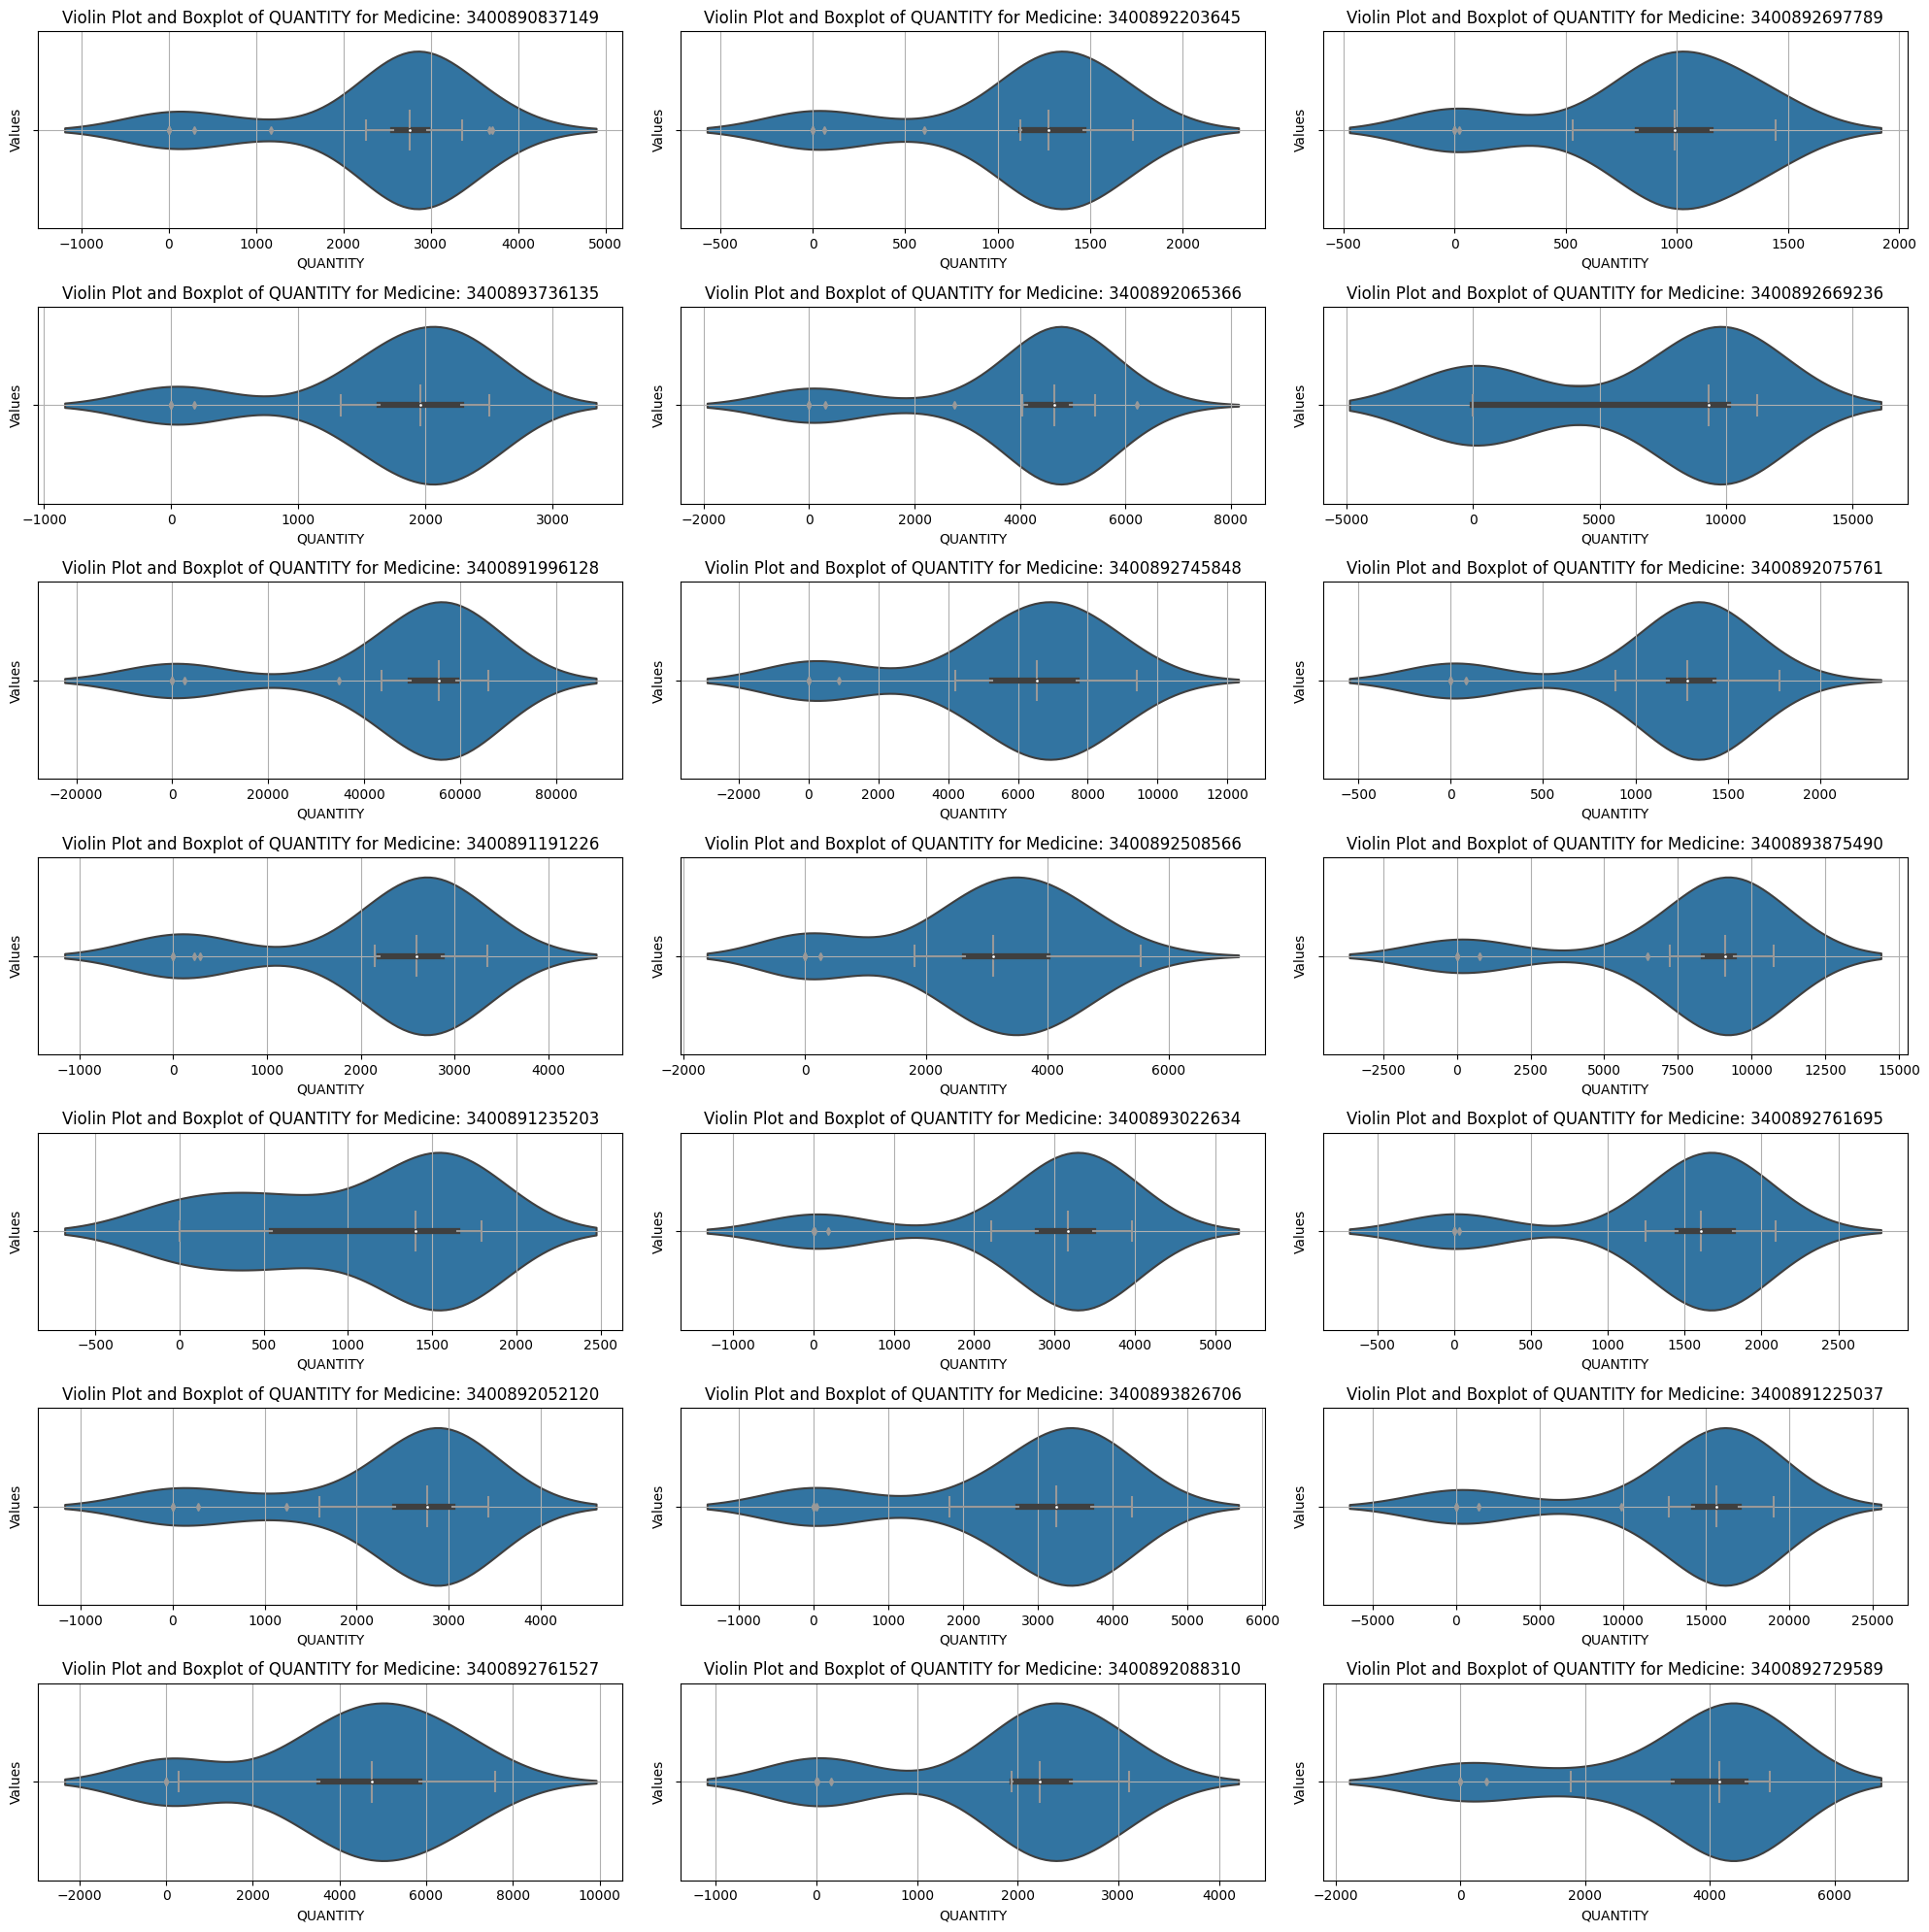

In [21]:
plot_violin_boxplot_by_medicine(df_h1, 'QUANTITY')

## 2.4 - Transforming categorical features

In [117]:
df_h1_modified = df_h1.copy()

df_h1_modified['MONTH'] = df_h1_modified['DATE'].dt.month
df_h1_modified['WEEK'] = df_h1_modified['DATE'].dt.isocalendar().week

df_h1_modified["HOSPI_CODE_UCD"] = df_h1_modified["HOSPI_CODE_UCD"].astype(int)
df_h1_modified = df_h1_modified[(df_h1_modified["HOSPI_CODE_UCD"] != 3400891996128)]

change = {'N05BA04':'1', 'H02AB06':'2', 'M03BX01':'3',
          'A03AX12':'4', 'B01AC06':'5', 'B01AB05':'6',
          'N02BE01':'7', 'R03AC02':'8', 'N05BA12':'9',
          'N05CF01':'10', 'C01CA03':'11', 'N05CF02':'12',
          'J01CR05':'13', 'B05XA03':'14', 'N02AX02':'15',
          'B05XA09':'16', 'A12BA01':'17', 'C03CA01':'18'}

df_h1_modified["CODE_ATC"] = df_h1_modified['CODE_ATC'].replace(change)
df_h1_modified["CODE_ATC"] = df_h1_modified["CODE_ATC"].astype(int)

# 3 - Feature manipulation and comprehension

In [118]:
df_h1_modified = df_h1_modified.drop(['N_ETB','SEJ_HAD', 'SEJ_PSY'], axis=1)

## 3.1 - Correlation analysis

<Axes: >

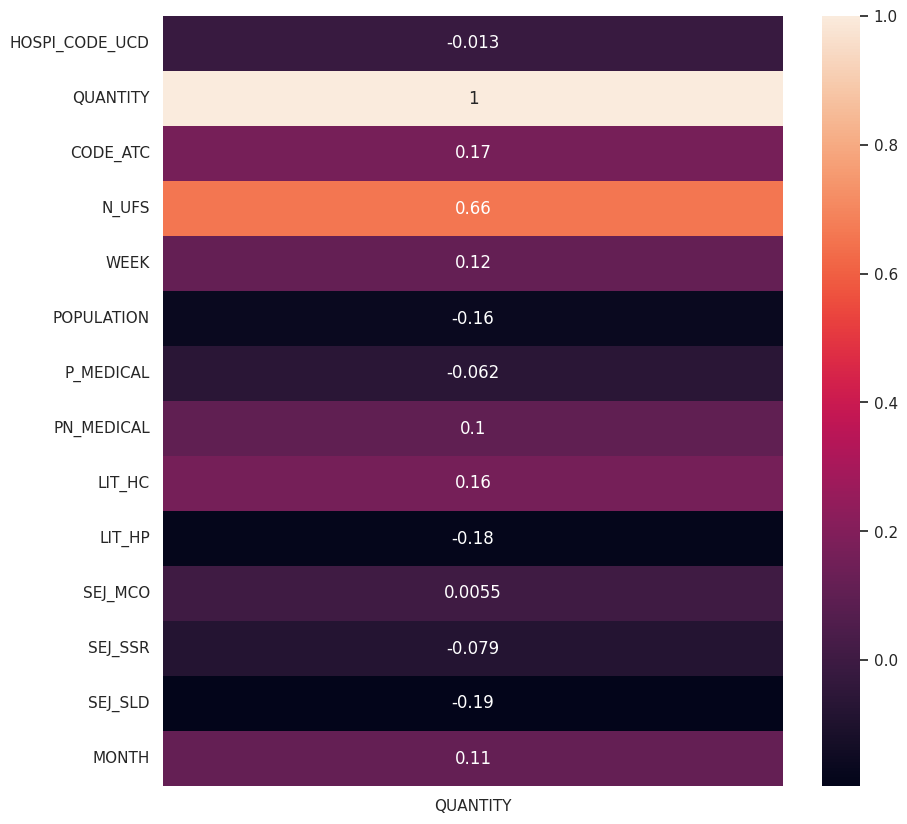

In [119]:
corr = df_h1_modified.corr(numeric_only=True)
x = corr[['QUANTITY']]
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(x,annot=True)

<Axes: >

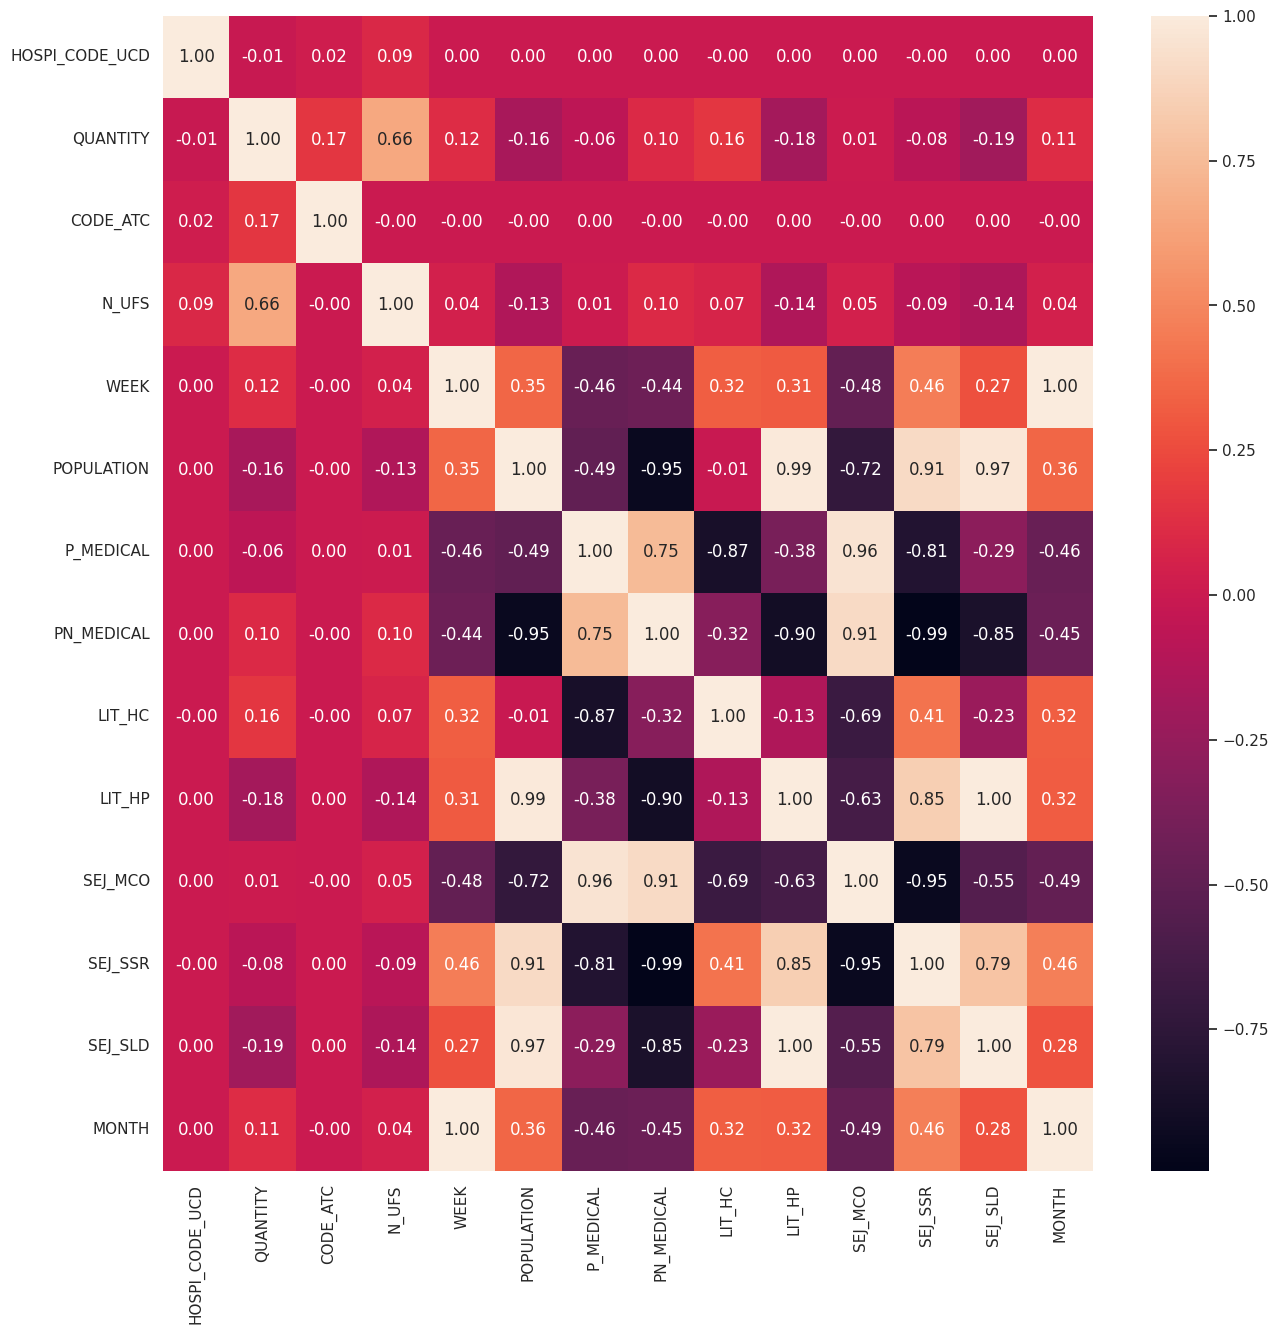

In [120]:
'''
  The constant values are not displayed in the correlation.
'''
corr = df_h1_modified.corr(numeric_only=True)
sns.set(rc={'figure.figsize': (15, 15)})
sns.heatmap(corr, annot=True, fmt='.2f')


## 3.2 - Normalize / Scale data

### Standardize the features

In [123]:
# Normalizing data
X = df_h1_modified.drop('DATE', axis=1).values
X.shape

(500, 14)

In [124]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

## 3.3 - Dimensionality reduction with PCA

Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.


In Scikit-learn, [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is applied using the PCA() class. It is in the decomposition submodule in Scikit-learn. The most important hyperparameter in that class is n_components.


The construction of relevant features is achieved by linearly transforming correlated variables into a smaller number of uncorrelated variables. This is done by projecting (dot product) the original data into the reduced PCA space using the eigenvectors of the covariance/correlation matrix aka the principal components (PCs). [[towards dqtqscience](https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e)]


In [125]:
pca_12 = PCA(n_components = X.shape[1], random_state = 42)
pca_12.fit(X_scaled)
X_pca_12 = pca_12.transform(X_scaled)

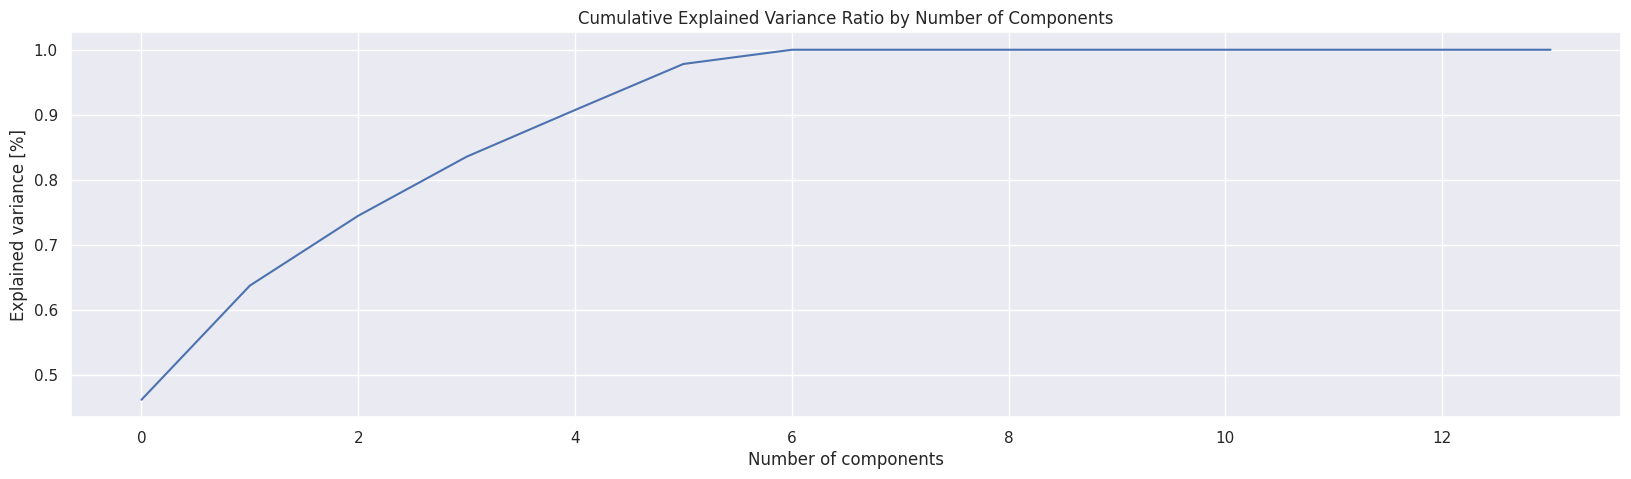

In [126]:
'''
  We can notice here that the first 6 components keep 99% of the variability
  in the dataset while reducing 12 features in the dataset.
'''

cumsum_X = np.cumsum(pca_12.explained_variance_ratio_)

# Set the figure size to 12 by 12
plt.figure(figsize=(20, 5))

plt.plot(cumsum_X)
plt.xlabel('Number of components')
plt.ylabel('Explained variance [%]')

# Set the tick locations and labels
tick_locations = np.arange(0, len(cumsum_X), 2)
tick_labels = np.arange(0, len(cumsum_X), 2, dtype=int)
plt.xticks(tick_locations, tick_labels)

plt.title("Cumulative Explained Variance Ratio by Number of Components")

plt.show()


### PCA2

In [127]:
pca_2 = PCA(n_components = 2, random_state = 42)
pca_2.fit(X_scaled)
X_pca_2 = pca_2.transform(X_scaled)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

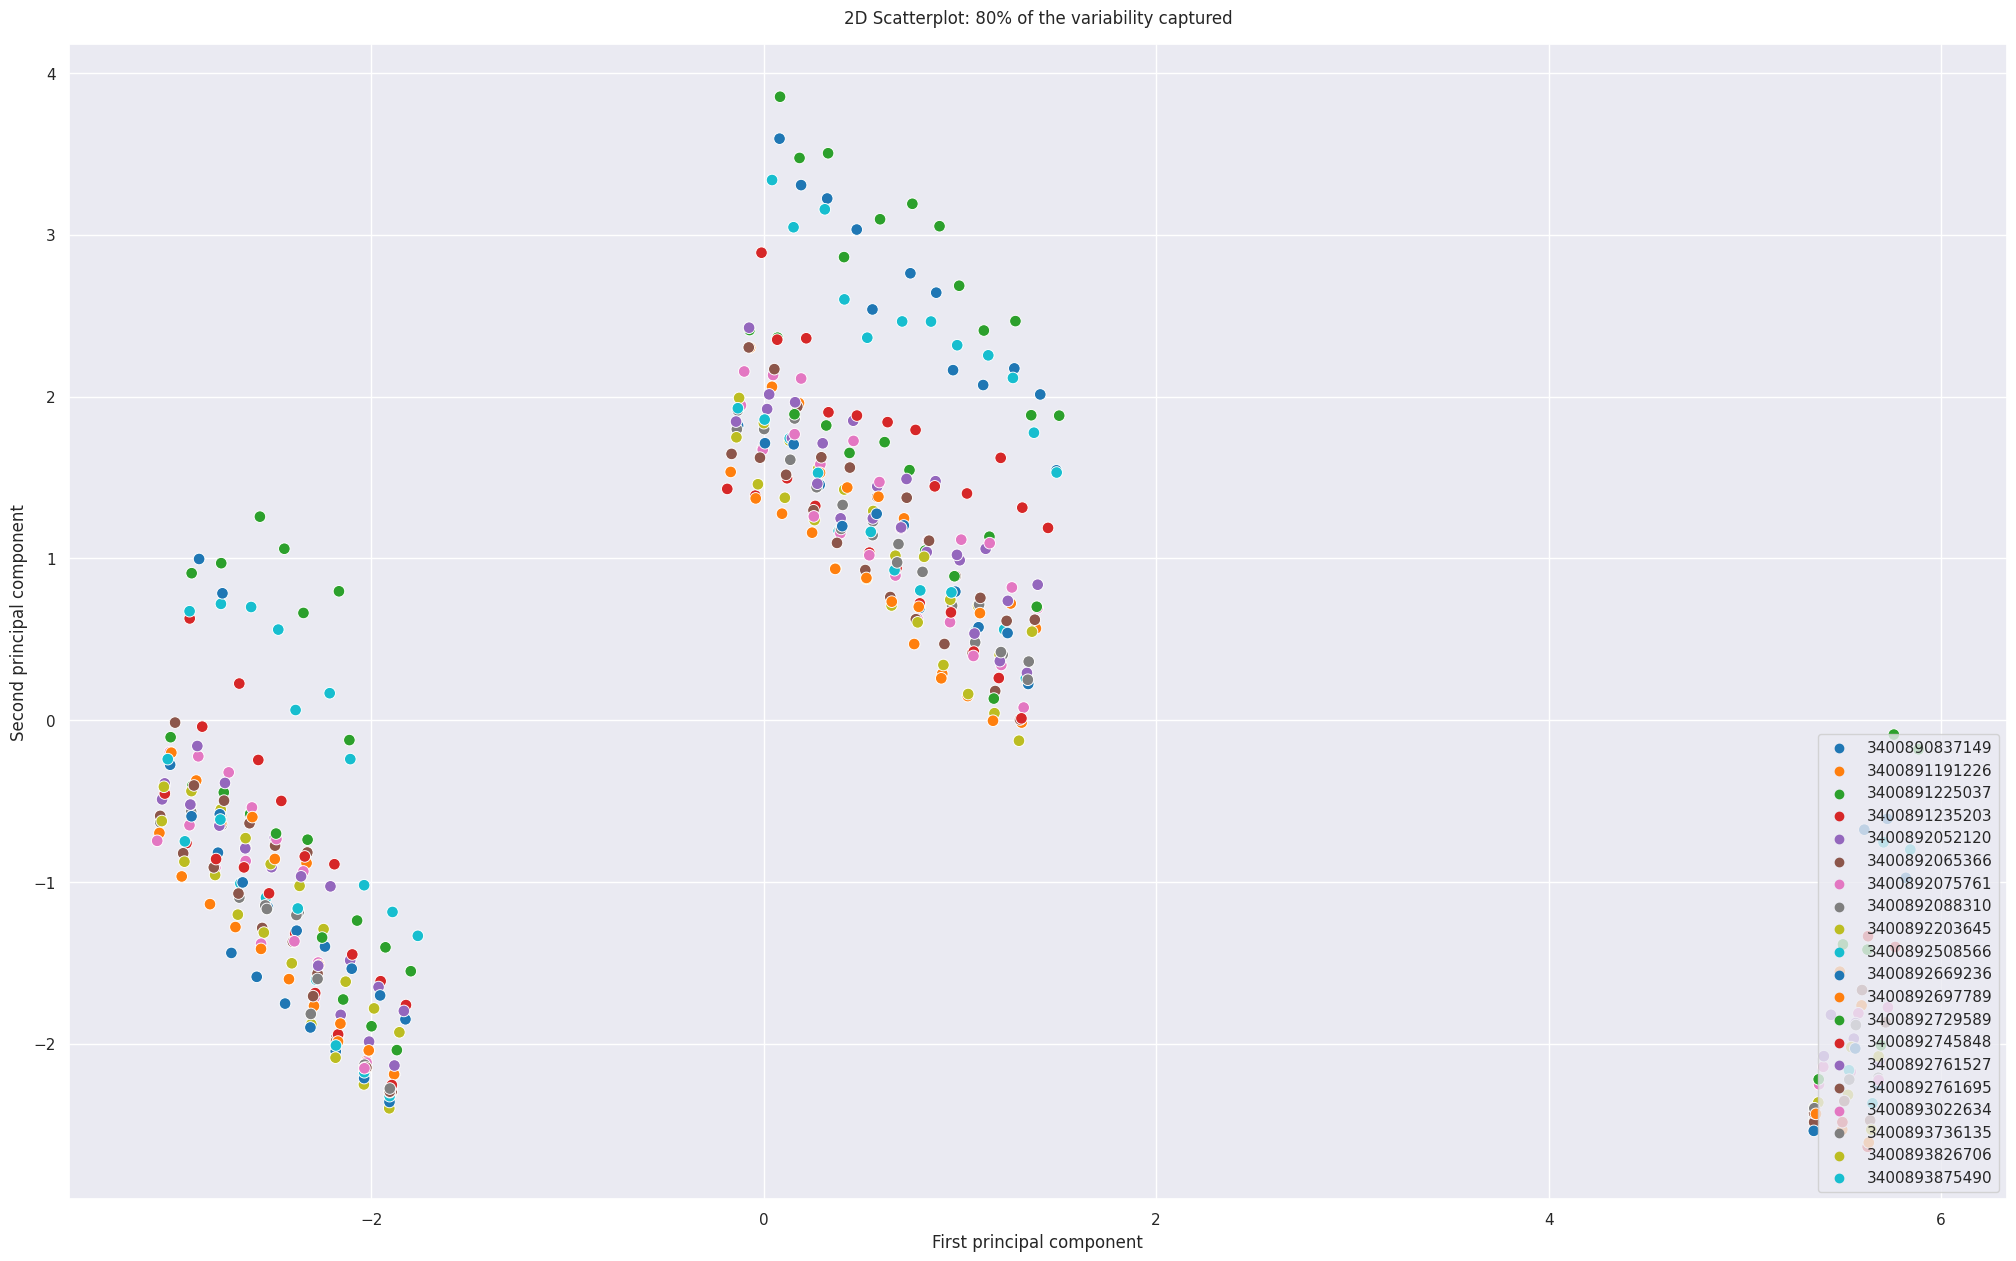

In [128]:
plt.figure(figsize = (25,15))

sns.scatterplot(x = X_pca_2[:,0], y = X_pca_2[:,1], s = 70,
                hue = df_h1_modified.HOSPI_CODE_UCD, palette='tab10')

plt.title('2D Scatterplot: 80% of the variability captured', pad=15)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend(loc='lower right')
plt.plot

### PCA 3

In [129]:
pca_3 = PCA(n_components = 3, random_state = 42)
pca_3.fit(X_scaled)
X_pca_3 = pca_3.transform(X_scaled)

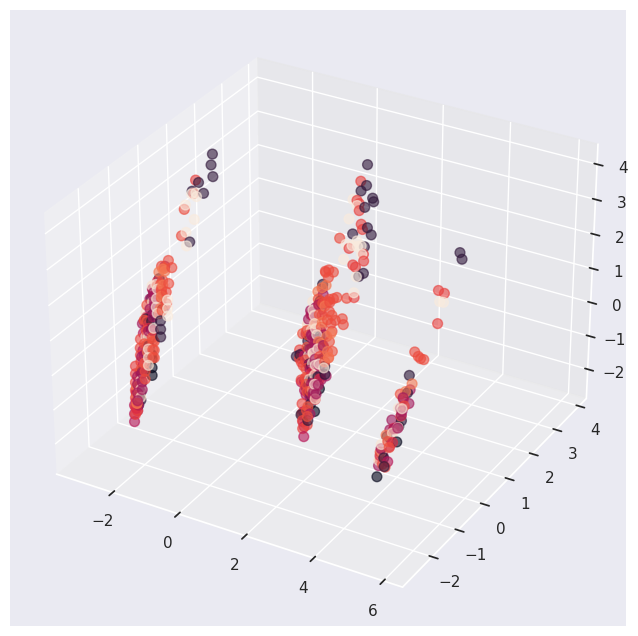

In [130]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (12,8))
ax = plt.axes(projection='3d')

sctt = ax.scatter3D(X_pca_3[:,0], X_pca_3[:,1], X_pca_3[:,2],
                    c = df_h1_modified.HOSPI_CODE_UCD, s = 50, alpha = 0.6)

### PCA 95

Let’s apply PCA to our dataset with n_components=0.95. This will select the number of components while preserving 95% of the variability in the data. The retrieved shape was (459,7), which means that the algorithm has found 7 principal components to preserve 95% of the variability in the data.

In [131]:

'''
  pca_95.get_params(deep=True)
  {'copy': True,
  'iterated_power': 'auto',
  'n_components': 0.95,
  'n_oversamples': 10,
  'power_iteration_normalizer': 'auto',
  'random_state': 42,
  'svd_solver': 'auto',
  'tol': 0.0,
  'whiten': False}

'''
pca_95 = PCA(n_components = 0.95, random_state = 42)
pca_95.fit(X_scaled)
X_pca_95 = pca_95.transform(X_scaled)
X_pca_95.shape

(500, 6)

In [132]:
df_h1_reduced = pd.DataFrame(X_pca_95,
                             columns = ['PC01','PC02','PC03',
                                        'PC04','PC05','PC06'])
df_h1_reduced.head()

,PC01,PC02,PC03,PC04,PC05,PC06
0,-1.825063,-1.848061,-0.310412,1.238783,0.112435,2.777792
1,-1.907574,-2.398051,-1.295166,0.854937,-0.656760,1.160717
2,-1.895077,-2.298442,-1.038388,1.014200,-1.032995,0.715608
3,-1.882193,-2.189230,-0.720322,1.230776,-1.901228,-0.135006
4,-1.895147,-2.294074,-1.042296,1.003295,-0.221298,0.902558


# 4 - Clustering

## 4.1 - Train, test split

In [133]:
Xnorm = Normalizer().fit_transform(df_h1_reduced.values)
X_train, X_test = train_test_split(Xnorm, test_size = 0.2, random_state=42)

## 4.2 - K-means different models and 4.3 - Model evaluation



In [134]:
min_clusters = 2
max_clusters = len(df_h1.HOSPI_CODE_UCD.unique())

s_scores = np.zeros(max_clusters-1)
dbs_scores = np.zeros(max_clusters-1)
calinski_scores = np.zeros(max_clusters-1)

clusters = range(2, max_clusters + 1)

for n_clusters in clusters:

  s_scores[n_clusters-2], dbs_scores[n_clusters-2], calinski_scores[n_clusters-2] =  evaluate_kmeans_clustering(X_train, X_test, n_clusters)



---------------------------------------------------------------------
---------------------------------------------------------------------

########## Metrics best performance for different clusters ##########
Best score for Silhouette metric: 0.42 for 3 clusters
Best score for Davies Bouldin metric: 0.95 for 20 clusters
Best score for Calinski metric: 69.43 for 2 clusters

---------------------------------------------------------------------
---------------------------------------------------------------------



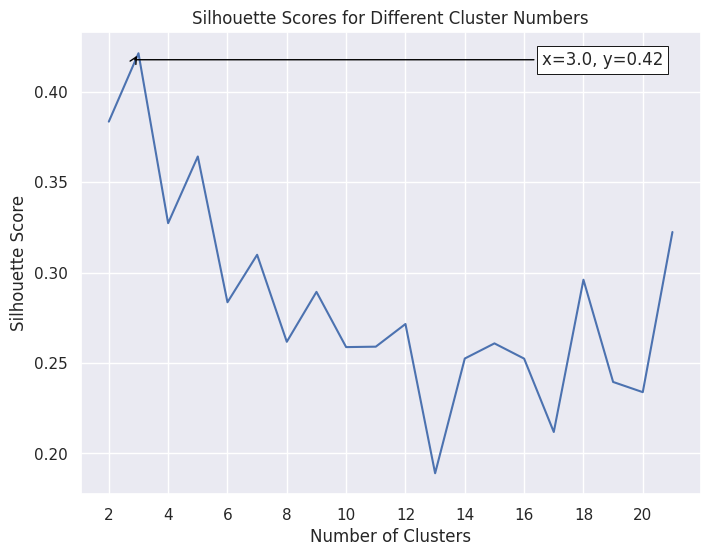

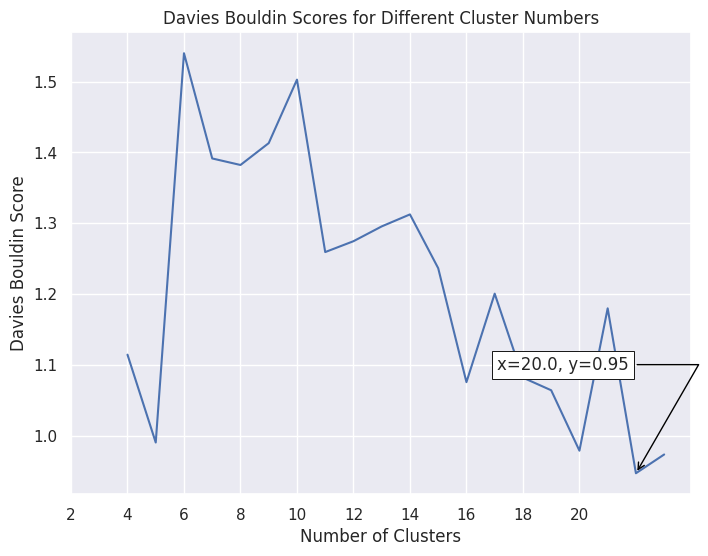

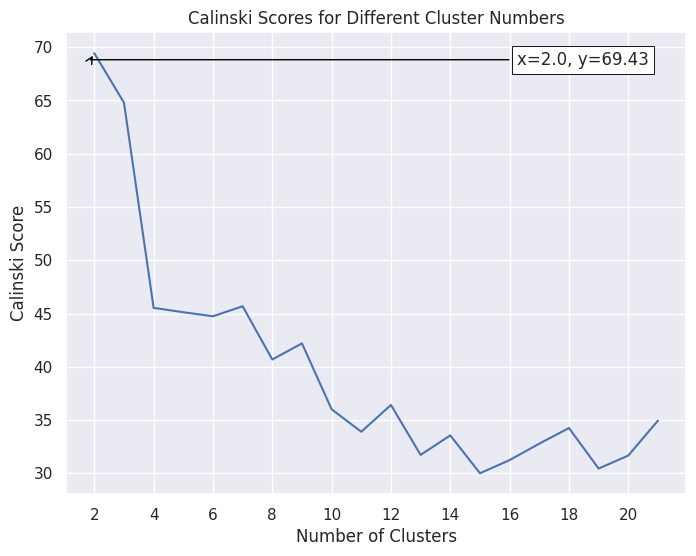

In [135]:
visualize_kmeans_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, calinski_scores)

In [136]:
model = KMeans(n_clusters=4, init = 'k-means++', n_init=1, max_iter=300)
labels  = model.fit_predict(df_h1_reduced.values)

df_h1_modified['cluster'] = labels

description = df_h1_modified.groupby("cluster")["QUANTITY", "POPULATION", "P_MEDICAL", "PN_MEDICAL"]
n_drugs = description.size()
description = description.mean()
description['n_drugs'] = n_drugs
description

<ipython-input-136-34dc33683924>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  description = df_h1_modified.groupby("cluster")["QUANTITY", "POPULATION", "P_MEDICAL", "PN_MEDICAL"]


,QUANTITY,POPULATION,P_MEDICAL,PN_MEDICAL,n_drugs
cluster,,,,,
0,612.323232,572443.0,806.0,5303.0,99
1,4370.458333,570662.0,805.0,5362.0,240
2,2971.300000,569894.0,843.0,5438.0,60
3,4571.792079,572443.0,806.0,5303.0,101


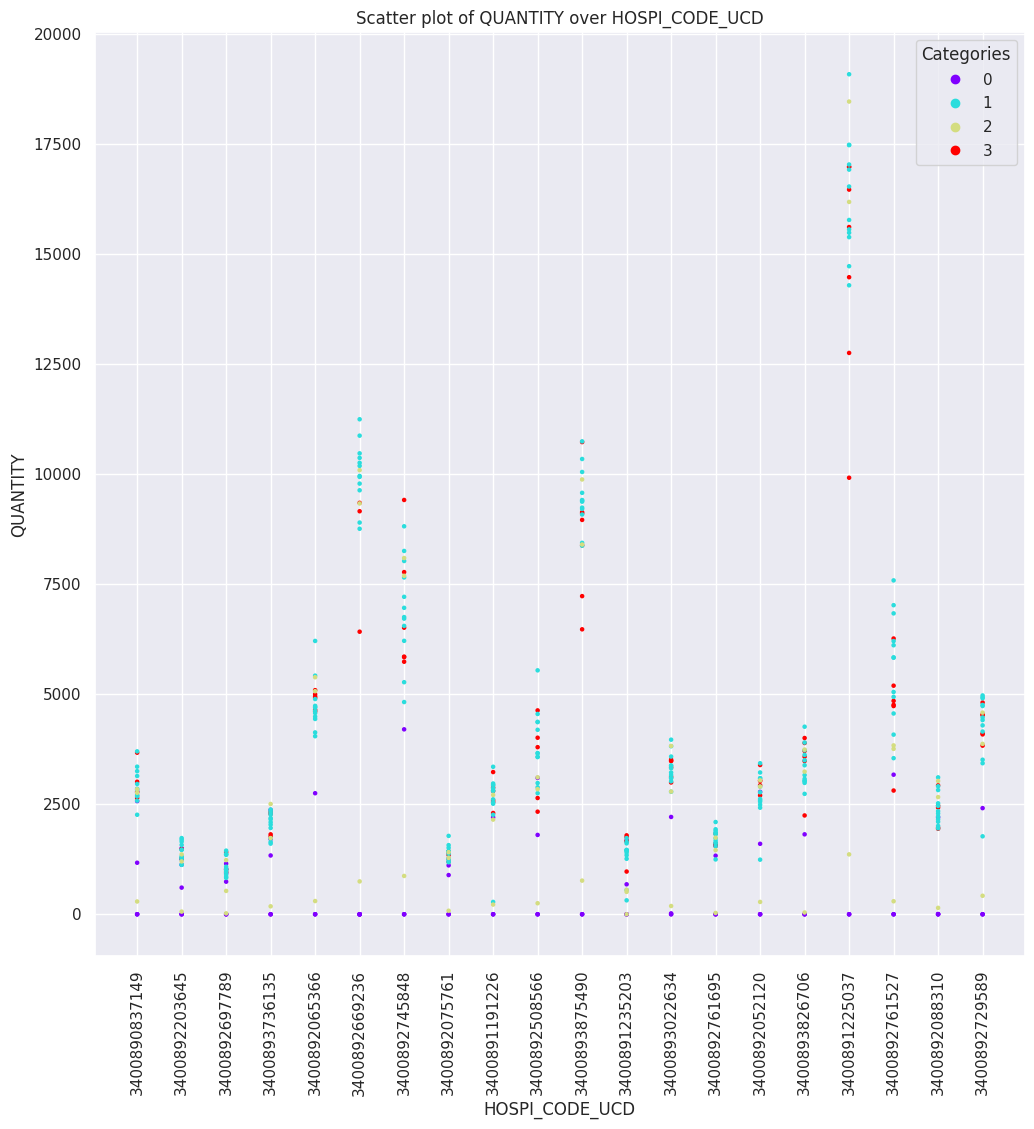

In [137]:
plt.figure(figsize=(12, 12))
scatter = plt.scatter(df_h1_modified["HOSPI_CODE_UCD"].astype('string'), df_h1_modified["QUANTITY"], c=labels, s=5, cmap='rainbow')
plt.xlabel("HOSPI_CODE_UCD")
plt.ylabel("QUANTITY")
plt.title("Scatter plot of QUANTITY over HOSPI_CODE_UCD")
plt.xticks(rotation=90)
plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1], title="Categories")
plt.show()

# Clustering without PCA

In [138]:
X_train, X_test = train_test_split(X_scaled, test_size = 0.2, random_state=42)

In [139]:
min_clusters = 2
max_clusters = len(df_h1.HOSPI_CODE_UCD.unique())

s_scores = np.zeros(max_clusters-1)
dbs_scores = np.zeros(max_clusters-1)
calinski_scores = np.zeros(max_clusters-1)

clusters = range(2, max_clusters + 1)

for n_clusters in clusters:

  s_scores[n_clusters-2], dbs_scores[n_clusters-2], calinski_scores[n_clusters-2] =  evaluate_kmeans_clustering(X_train, X_test, n_clusters)



---------------------------------------------------------------------
---------------------------------------------------------------------

########## Metrics best performance for different clusters ##########
Best score for Silhouette metric: 0.48 for 2 clusters
Best score for Davies Bouldin metric: 0.76 for 2 clusters
Best score for Calinski metric: 86.57 for 3 clusters

---------------------------------------------------------------------
---------------------------------------------------------------------



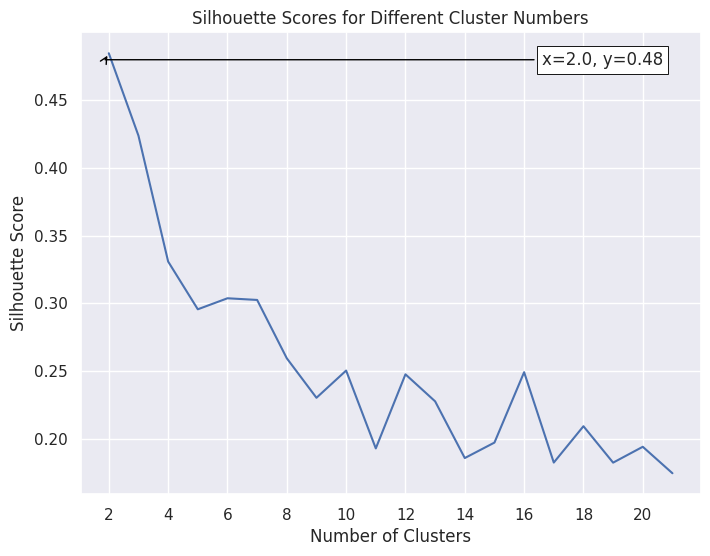

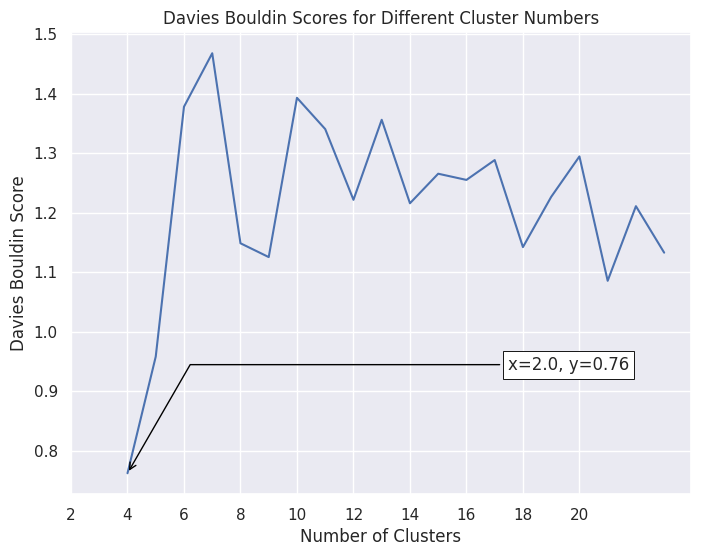

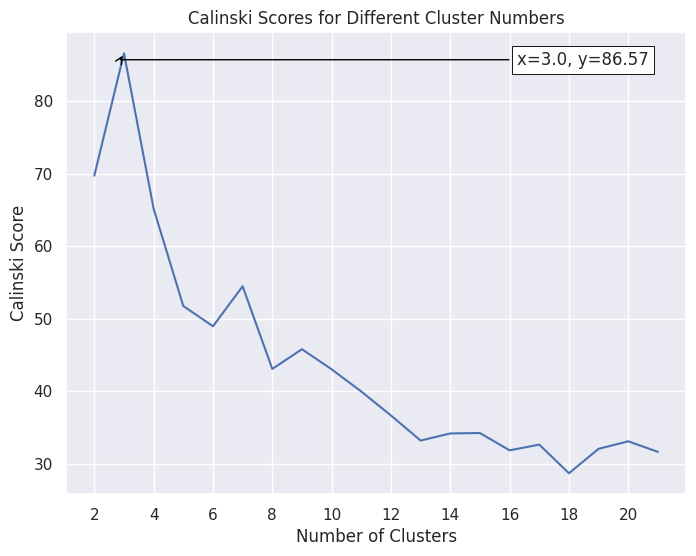

In [140]:
visualize_kmeans_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, calinski_scores)

In [141]:
model = KMeans(n_clusters=4, init = 'k-means++', n_init=1, max_iter=300)
labels  = model.fit_predict(df_h1_reduced.values)

df_h1_modified['cluster'] = labels

description = df_h1_modified.groupby("cluster")["QUANTITY", "POPULATION", "P_MEDICAL", "PN_MEDICAL"]
n_drugs = description.size()
description = description.mean()
description['n_drugs'] = n_drugs
description

<ipython-input-141-34dc33683924>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  description = df_h1_modified.groupby("cluster")["QUANTITY", "POPULATION", "P_MEDICAL", "PN_MEDICAL"]


,QUANTITY,POPULATION,P_MEDICAL,PN_MEDICAL,n_drugs
cluster,,,,,
0,2611.855000,572443.0,806.0,5303.0,200
1,4459.450000,570662.0,805.0,5362.0,120
2,2971.300000,569894.0,843.0,5438.0,60
3,4281.466667,570662.0,805.0,5362.0,120


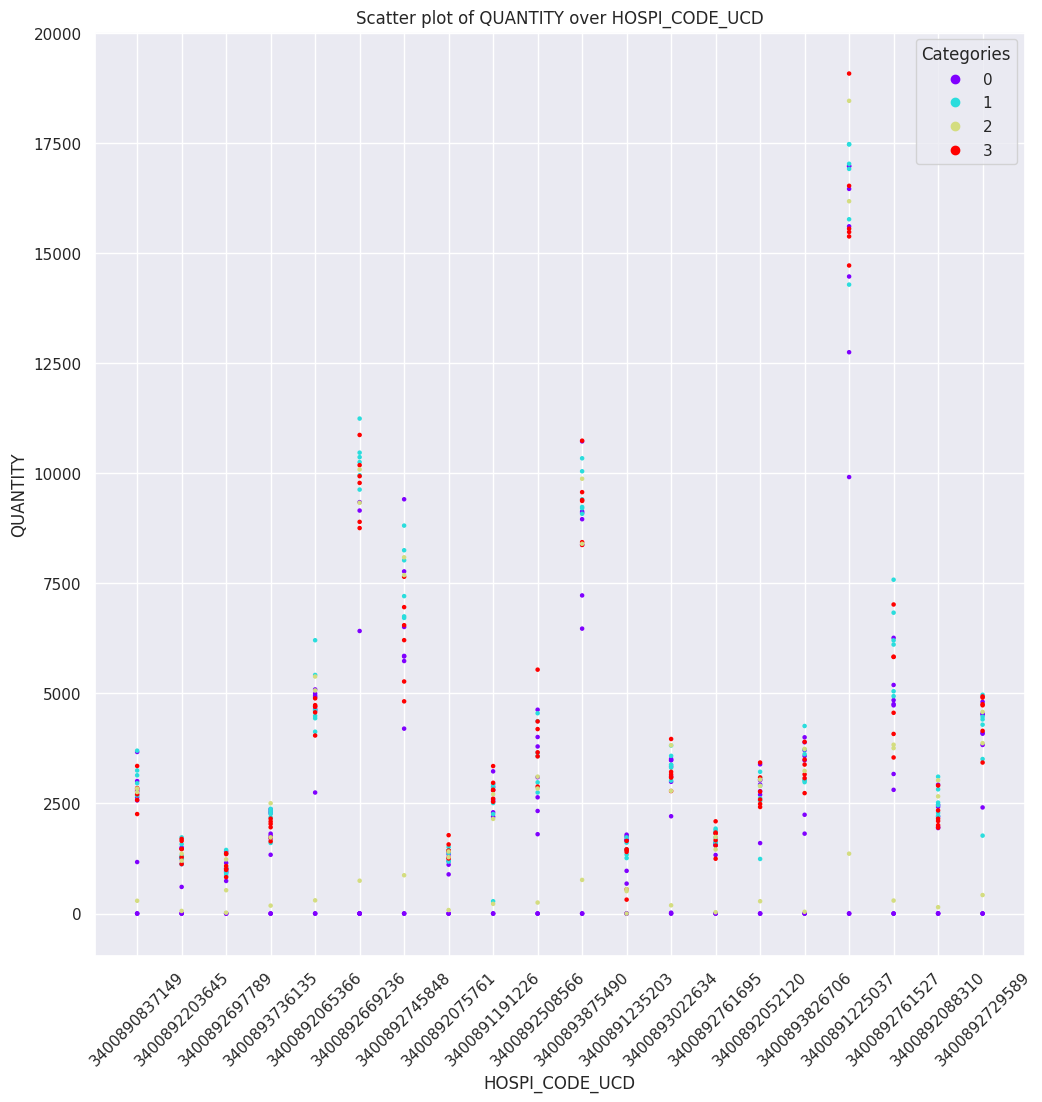

In [142]:
plt.figure(figsize=(12, 12))
scatter = plt.scatter(df_h1_modified["HOSPI_CODE_UCD"].astype('string'), df_h1_modified["QUANTITY"], c=labels, s=5, cmap='rainbow')
plt.xlabel("HOSPI_CODE_UCD")
plt.ylabel("QUANTITY")
plt.title("Scatter plot of QUANTITY over HOSPI_CODE_UCD")
plt.xticks(rotation=45)
plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1], title="Categories")
plt.show()

# Moving average

In [216]:
def calculate_moving_average(df, column, period):
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original

    for medicine in df_copy['HOSPI_CODE_UCD'].unique():
        mask = df_copy['HOSPI_CODE_UCD'] == medicine
        ma_column = column + '_MA'

        # Calculate the moving average
        df_copy.loc[mask, ma_column] = df_copy.loc[mask, column].rolling(window=period, min_periods=1).mean()

        # Normalize the moving average
        max_ma = df_copy.loc[mask, ma_column].max()
        min_ma = df_copy.loc[mask, ma_column].min()
        df_copy.loc[mask, column + '_MA_normalized'] = (df_copy.loc[mask, ma_column] - min_ma) / (max_ma - min_ma)

    return df_copy


In [238]:
def scatterplot_quantity(df, column, period):
    plt.figure(figsize=(20, 20))
    colors = plt.cm.viridis(np.linspace(0, 1, len(df['HOSPI_CODE_UCD'].unique())))

    for i, code in enumerate(df['HOSPI_CODE_UCD'].unique()):
        subset = df[df['HOSPI_CODE_UCD'] == code]
        plt.plot(subset['DATE'], subset[column], marker='o', linewidth=0.5, color=colors[i], label=code)

    plt.xlabel('DATE')
    plt.ylabel('Quantity')
    plt.title('Scatter Plot of Quantity moving average for the period of: '+f'{period} months' )
    plt.xticks(rotation=45)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='HOSPI_CODE_UCD')
    plt.grid(True)
    plt.show()


In [ ]:
import numpy as np

def calculate_moving_average(vector, period):
    """
    Calculates the moving average for a given period.

    Args:
        vector (array-like): Input vector.
        period (int): Period for the moving average calculation.

    Returns:
        array-like: Moving average vector.
    """
    # Create an array to store the moving average values
    moving_average = np.zeros_like(vector)

    # Calculate the moving average for each index in the vector
    for i in range(len(vector)):
        start = max(0, i - period + 1)
        end = i + 1
        moving_average[i] = np.mean(vector[start:end])

    return moving_average


In [240]:
df_ma_3 = calculate_moving_average(df_h1_modified, 'QUANTITY', 3)
df_ma_3 = df_ma_3.sort_index(axis=1).reset_index(drop=True)

In [242]:
#Validation
plt.plot(df_ma_3[(df_ma_3['DATE'] > pd.to_datetime('2017-09-01')) & (df_ma_3['HOSPI_CODE_UCD'] == 3400892761695)]['QUANTITY'])


In [241]:
scatterplot_quantity(df_ma_3[df_ma_3['DATE'] > pd.to_datetime('2017-09-01')], 'QUANTITY_MA', 3)

<IPython.core.display.Javascript object>

In [237]:
df_ma_6 = calculate_moving_average(df_h1_modified, 'QUANTITY', 6)
df_ma_6 = df_ma_6.sort_index(axis=1).reset_index(drop=True)
scatterplot_quantity(df_ma_6[df_ma_6['DATE'] > pd.to_datetime('2017-09-01')], 'QUANTITY_MA', 6)

<IPython.core.display.Javascript object>

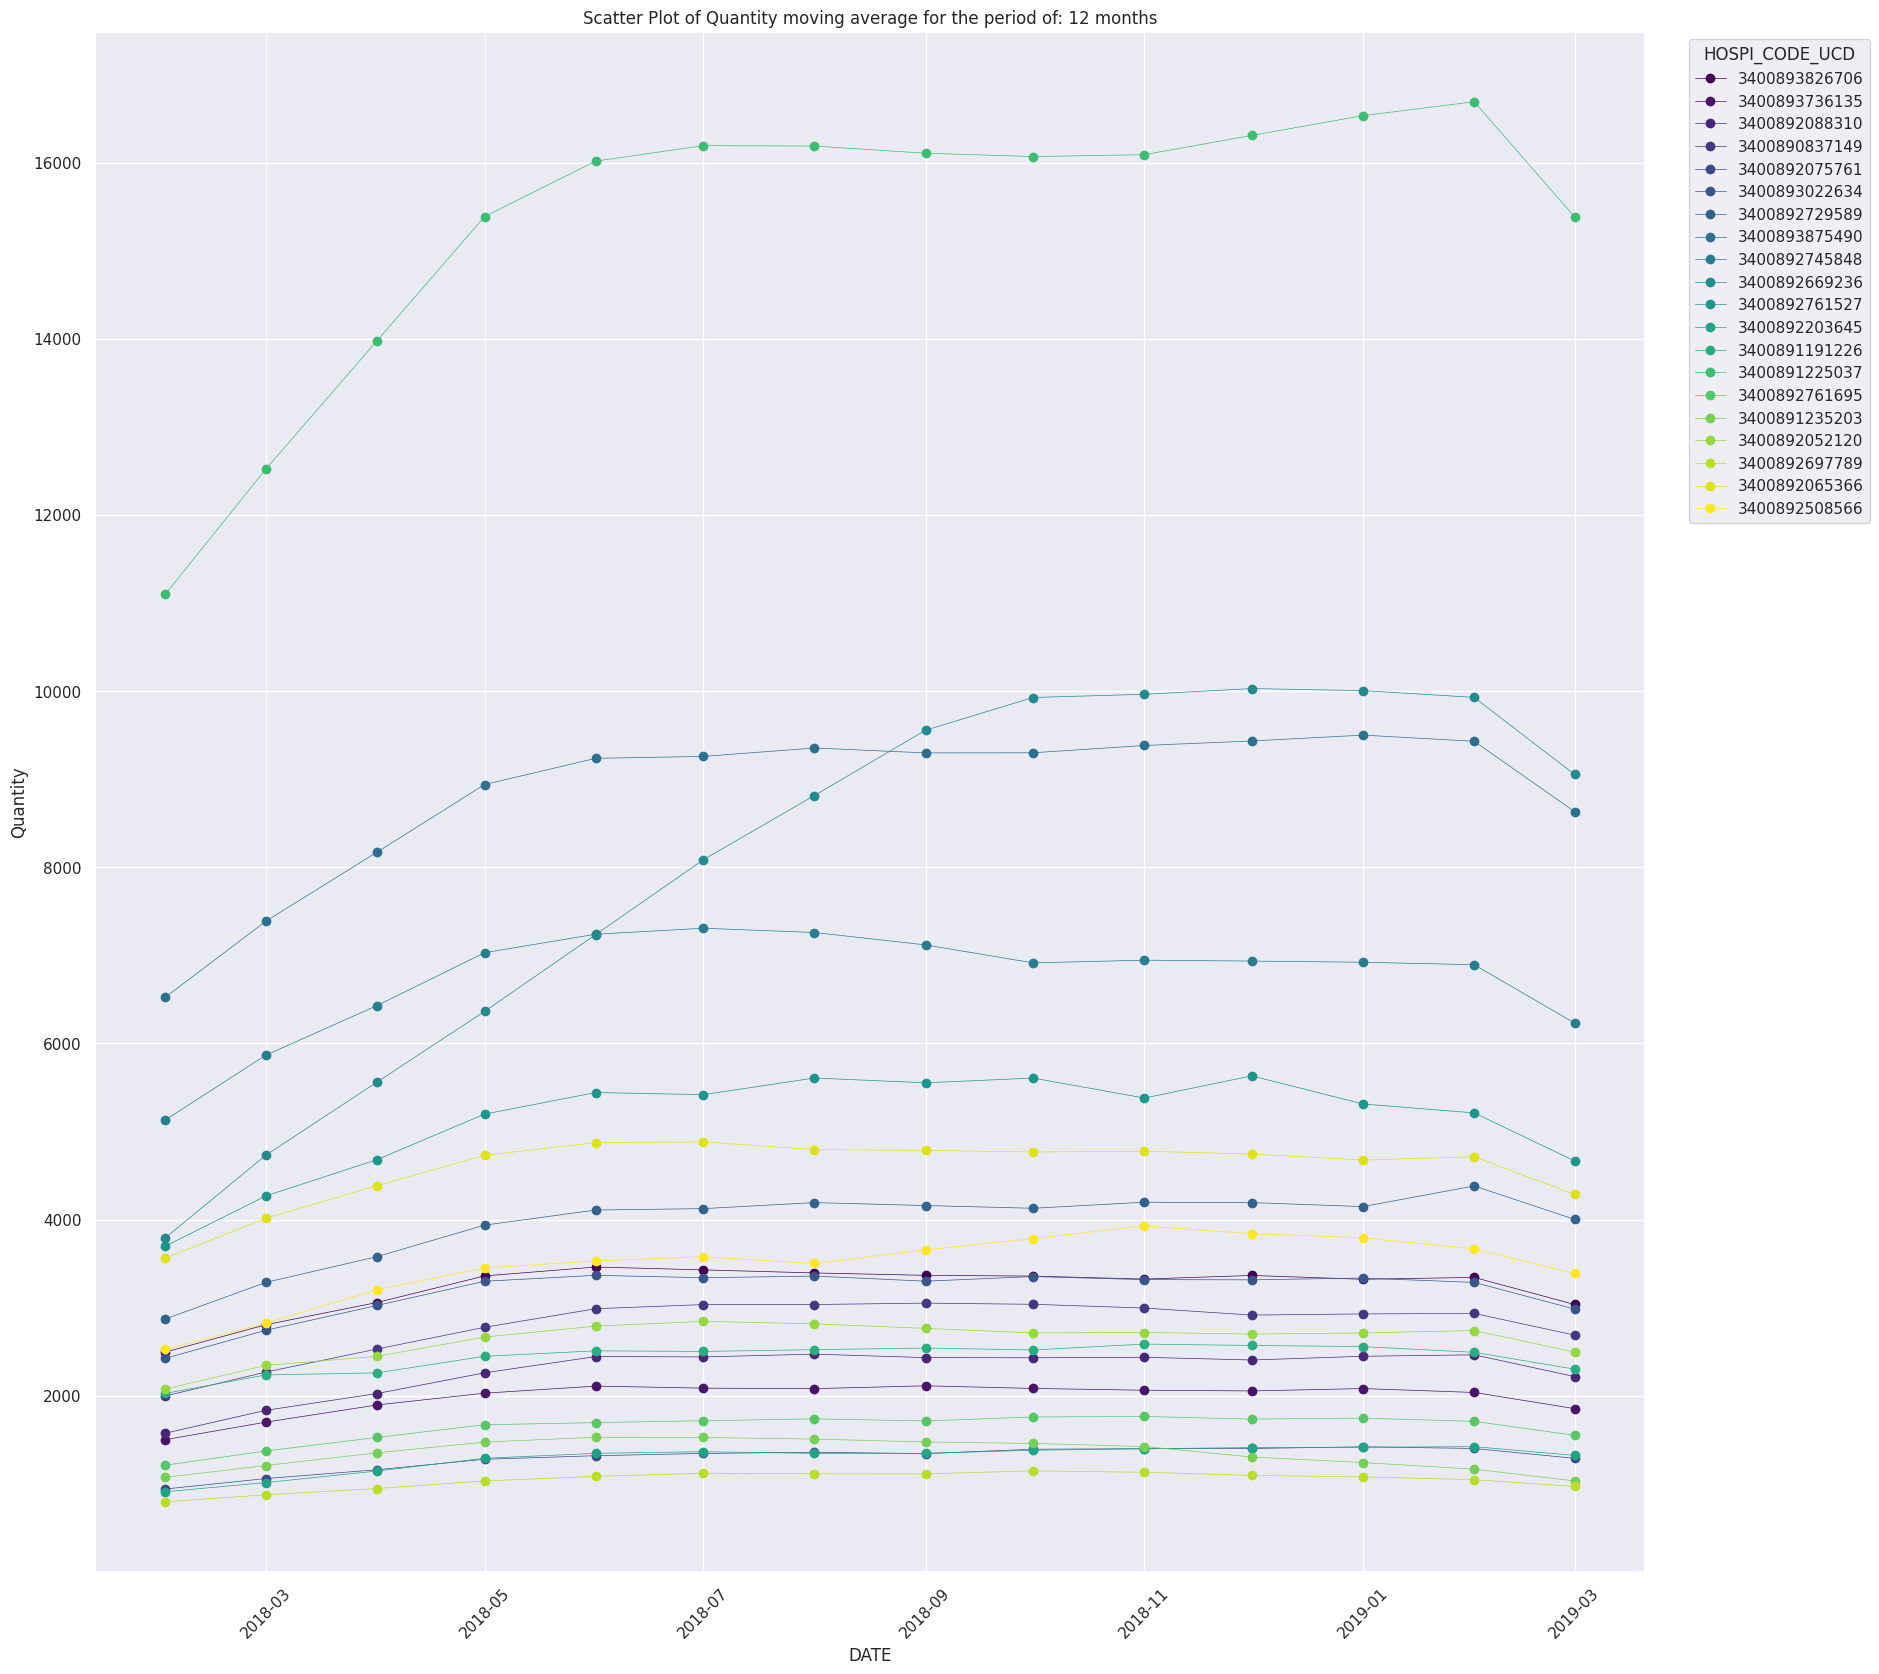

In [210]:
df_ma = calculate_moving_average(df_h1_modified, 'QUANTITY', 12)
df_ma = df_ma.sort_index(axis=1).reset_index(drop=True)
scatterplot_quantity(df_ma[df_ma['DATE'] > pd.to_datetime('2017-09-01')], 'QUANTITY_MA',12)